# Quick Reference



### Just give me a plot

    result = proj.run_sim(...)
    d = au.PlotData(result,pops=['0-4'],outputs=['sus','vac'],project=proj)
    figs = au.plot_series(d,data=proj.data)

### FAQs

##### Data manipulation
- [How do I sum over all populations?](#Data-preparation-and-aggregation)
- [How do I transform output quantities?](#Function-aggregations)
- [I want to integrate my data over time](#Time-accumulation)
- [I want to aggregate my data over time](#Time-aggregation)
- [I want to plot flow rates](#Plotting-transition-parameters-and-flow-rates)
- [I want to plot a specific link](#Flow-rate-aggregations-and-disaggregations)
- [How do I get actual annual flow quantities](#Time-aggregation-of-flow-rates)

##### General issues
- [The plot uses code names instead of full names](#Setting-full-names)
- [I want lines for populations, not for outputs](#Plotting-series)
- [How do I save figures to PNG files?](#Saving-figures)
- [Something is wrong with the units](#Axis-units)
- [I want different colours](#Setting-colors)

##### Bar graphs

- [I want to make a bar graph](#Plotting-bars)
- [I want to stack things on the bar graph](#Stacking-bars)
- [I want to label the bars differently](#Labelling-bars)
- [I want horizontal bars](#Horizontal-bars)

##### Legends

- [Something is wrong with the legend](#Working-with-legends)
- [I want the legend to be in a different order](#Controlling-legend-order)
- [I want to specify custom legend labels](#Relabeling-legend-entries)

<div class="alert alert-info">
The plotting library is big! This quick reference is just a small preview of implemented functionality. See the full documentation below for details on all of the plotting possibilities.
</div>

# Atomica Plotting Documentation

Making plots in Atomica is intrinsically complex, because customization is required in several places

- Aggregating outputs by summation or averaging
- Aggregating outputs across populations
- Collapsing values over time
- Comparing outputs or pops within results, or comparing across results
- Stacking bars with groups of variables
- Setting colours for individual quantities, or sets of quantities
- Setting axis limits to focus on particular times or values
- Having legends together with the figure, or in a separate figure
- Optionally having names converted to long names 
- Setting custom axis labels and titles
- Saving output figures

This notebook provides documentation for the plotting library, providing an overview of available functions and examples of how to perform common tasks. 

_Note that this plotting library serves as the foundation for accessing and plotting outputs - **it is expected that plots will require context-dependent customization after creation** to suit specific uses e.g. frontend, reports, presentations, and a number of helper scripts are also provided to assist with these customizations. The default behaviours in the plotting library reflect the lowest common denominator of usage, maximizing the information displayed and minimizing information loss_


In [1]:
# IMPORTS
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('..')
sys.path.append('../../sciris')
import atomica.ui as au
import matplotlib.pyplot as plt
import numpy as np
import sciris as sc
from IPython.display import display, HTML

CSS = """
.output {
    flex-flow: row wrap;
}
"""

HTML('<style>{}</style>'.format(CSS))


Atomica 1.0.8 (2018-10-14) -- (c) the Atomica development team
2018-10-18 14:16:27.848000
git branch: revised-num-covered (eba895e)


Load the default TB simulation, and run a scenario, so that we have two results - a `Result` corresponding to the baseline parameters, and a `Result` corresponding to the overwritten scenario parameters

In [2]:
proj = au.demo('tb')
par_results = proj.results[-1]

scvalues = dict()
scen_par = "doth_rate"
scen_pop = "0-4"
scvalues[scen_par] = dict()
scvalues[scen_par][scen_pop] = dict()
scvalues[scen_par][scen_pop]["y"] = [0.5,0.5]
scvalues[scen_par][scen_pop]["t"] = [1999., 2050.]
scen = proj.make_scenario(which='parameter',name="Increased deaths", instructions=scvalues)
scen_results = scen.run(proj,proj.parsets["default"])
par_results.name = 'Baseline'
scen_results.name = 'Scenario'
plt.rcParams['figure.figsize'] = (5,3) # Set figure sizing for this document

Creating a tb project...


Initialization characteristics are underdetermined - this may be intentional, but check the initial compartment sizes carefully


Initiating a standard run of project 'default' (i.e. without the influence of programs).
Elapsed time for running 'default' model: 1.04 s
Initiating a standard run of project 'default' (i.e. without the influence of programs).
Elapsed time for running 'default' model: 1.05 s


## Plotting system design 

Conceptually, there are 4 stages of plotting

1. Preparing data for plotting by aggregating e.g. summation, averaging
2. Rendering a standard plot
3. Applying customizations such as changing axis limits, modifying titles etc.
4. Saving an image of the plot to disk

Previously, all of these stages were controlled by arguments to a single function. However, this had two undesirable consequences

- The argument list for the plotting functions becomes very difficult to read because so many input options are available. This propagates into lower level functions as well. For example, in Optima TB the original `plotResult` function had 16 arguments, `innerPlotTrend` had 19 arguments, and `_plotTrends` had **38** arguments. 
- The number of different possibilities for execution within the function makes it difficult to predict the consequences of changes made to the code, making the code more difficult to maintain and debug

The root cause of the problem is that plotting is fundamentally a difficult problem because a lot of customization *is* essential. The single-function strategy attempts to simplify tasks for end users. While this works for individual tasks in isolation, when this strategy is scaled up to the whole system, it ends up making things more complicated for both developers and users. Further evidence that the existing strategy is not effective is that most plotting for applications is carried out in scripts like `plot_daru.py` which contains a number of application-specific plotting functions. The function calls to actually generate plots end up being calls to functions in the application's plotting module. As a result, even if the Optima TB plotting library separated some of the steps out, this would still be hidden from users within the application plotting functions. The application plotting functions could then play a greater role in making highly figure-specific customizations. 

We will now go through each of the 4 plotting stages in detail.

### Data preparation and aggregation

All plotting starts with the creation of a `PlotData` object. This object is distinct from a `Result` object in three ways

- A `PlotData` object contains `Series` that are identified by a `[results,pops,outputs]` tuple. That is, it spans multiple results, which allows it to contain the relevant data for plotting scenarios
- A `Series` can be composed of multiple `Outputs` from a simulation. That is, it can contain quantities that are derived from transformations of simulation results, that are computed on a plot-specific basis. This makes it possible to easily work with quantities that were not originally specified in the project framework.
- A `Series` contains a specification of formatting options, such as color, which are not stored in a `Result` object

In sum, a `PlotData` object is a container for all of the data that appears on a plot. A `PlotData` object should be instantiated when a plot is about to be generated. A basic example is shown below

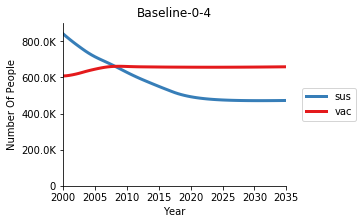

In [3]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = au.plot_series(d)

Data in a `PlotData` object can be aggregated in one of three ways

- Aggregation over outputs (sum, average, or weighted average, where the weighting is based on source compartment size). Note that a weighted average cannot be used for output parameters with no associated transitions, because there is no compartment size associated with those quantities
- Aggregation over populations (sum, average, or weighted average, where the weighting is based on population size)
- Aggregation over time (sum, or average) 

We will discuss the first two (output and population aggregation) now, and show time aggregation below in the context of bar plots. 

First, when instantiating a `PlotData` object, you need to specify a list of `results`, `pops`, and `outputs` that you want to display on the plot. The `results` are mandatory, because a `Result` is required to provide raw data. If not specified, by default `pops` is set to all of the populations in the `Result` and `outputs` is set to all of the compartments. You can specify as many or as few as you like. 

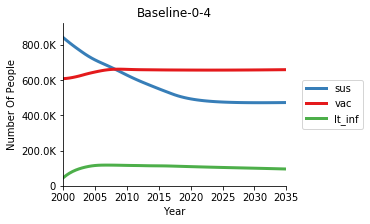

In [4]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['sus','vac','lt_inf'])
figs = au.plot_series(d)

As shown above, `pops` and `outputs` are specified as lists. If you want to specify an aggregation, instead of a string, pass in a dict where the key is name of your new aggregated output, and the value is the list of raw outputs to aggregate

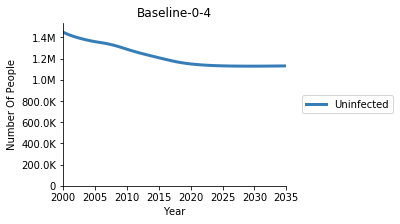

In [5]:
d = au.PlotData(par_results,pops=['0-4'],outputs=[{'Uninfected':['sus','vac']}])
figs = au.plot_series(d)

You can mix and match aggregations and raw outputs

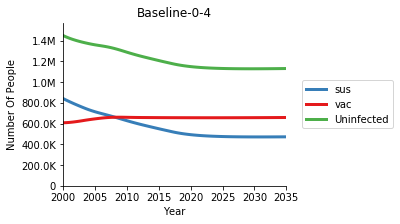

In [6]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = au.plot_series(d)

You can define multiple aggregations either by listing multiple dicts, or having multiple keys in a single dict:

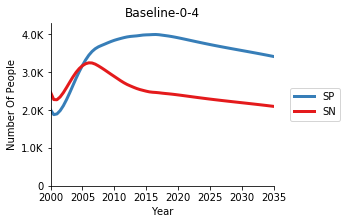

In [7]:
# Multiple dicts
d = au.PlotData(par_results,pops=['0-4'],outputs=[{'SP':['spdu','spdd','spdt']},{'SN':['sndu','sndd','sndt']}])
figs = au.plot_series(d)

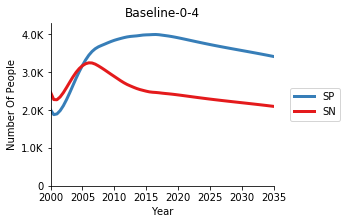

In [8]:
# Multiple keys
d = au.PlotData(par_results,pops=['0-4'],outputs=[{'SP':['spdu','spdd','spdt'],'SN':['sndu','sndd','sndt']}])
figs = au.plot_series(d)

You can also aggregate across both outputs and pops. Output aggregations are performed first, followed by population aggregations. 

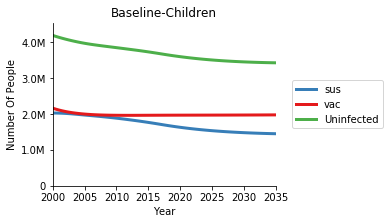

In [9]:
d = au.PlotData(par_results,pops=[{'Children':['0-4','5-14']}],outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = au.plot_series(d)

It is common to require aggregation over all populations. The special keyword `'total'` is provided for this purpose

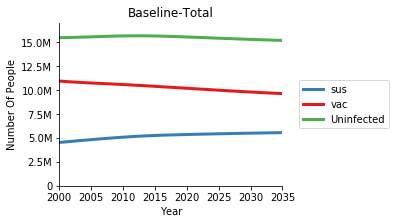

In [10]:
d = au.PlotData(par_results,pops='total',outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = au.plot_series(d)

By default, aggregation is performed by summing all of the values together. You can use the arguments `output_aggregation` and `pop_aggregation` to specify a different method. For example, to average the outputs:

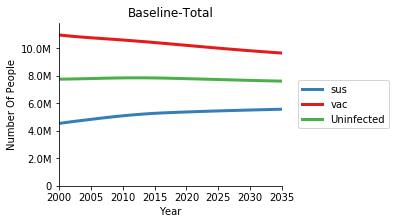

In [11]:
d = au.PlotData(par_results,output_aggregation='average',pops='total',outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = au.plot_series(d)

For outputs, a weighted average is based on compartment size (within populations), while for populations, a weighted average is based on the population size. The example below simply shows a weighted average of the compartment sizes, but in practice, the weighted average would be most useful for flow rates where the source compartment size is different to the flow rate.

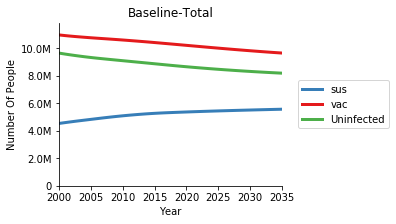

In [12]:
d = au.PlotData(par_results,output_aggregation='weighted',pops='total',outputs=['sus','vac',{'Uninfected':['sus','vac']}])
figs = au.plot_series(d)

Some aggregations do not make sense. For instance, if you aggregate prevalances, they should be averaged, not summed. In cases where the code is able to identify this, a warning will be displayed:

Output 'ac_prev' is not in number units, so population aggregation probably should not be 'sum'


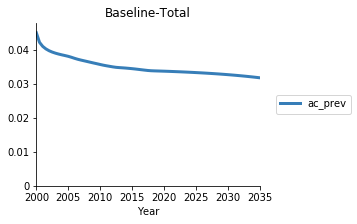

In [13]:
d = au.PlotData(par_results,pop_aggregation='sum',pops='total',outputs=['ac_prev'])
figs = au.plot_series(d)

If you do not specify an aggregation method, the aggregation method will automatically be selected based on the units of the quantity being plotted. Non-dimensional quantities, proportions, fractions, and prevalances will be averaged instead of summed. 

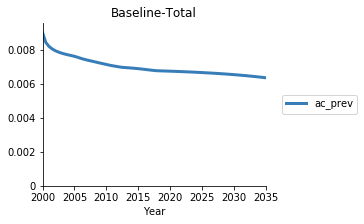

In [14]:
d = au.PlotData(par_results,pops='total',outputs=['ac_prev'])
figs = au.plot_series(d)

### Function aggregations

As well as defining aggregations, you can also define transformations of simulation quantities using arbitrary functions. This can only be done for outputs, not populations. To do this, define an output quantity as a `dict()` but provide a string containing the function to be evaluated, instead of a `list`. For instance

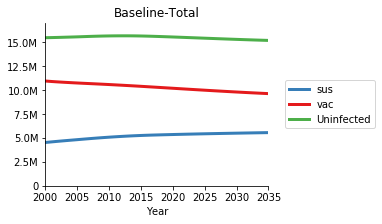

In [15]:
d = au.PlotData(par_results,pops='total',outputs=['sus','vac',{'Uninfected':'sus+vac'}])
figs = au.plot_series(d)

The variables that can appear inside the function are

- Compartment labels
- Characteristic labels
- Parameter labels
- Link labels (transition tags) - in which case, the value used will be the annualized flow rate summed over duplicate links

These are always accessed within a population. Because you can specify any function supported by the parsing system, you can use a function aggregation to dynamically compute prevalances and other quantities requiring more sophisticated transformations of the outputs:

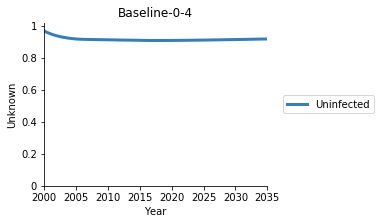

In [16]:
d = au.PlotData(par_results,pops='0-4',outputs=[{'Uninfected':'(sus+vac)/alive'}])
figs = au.plot_series(d)

One thing to be careful of in general is that fraction quantities should be aggregating by averaging, not summing. So if we wanted to compute the overall fraction of uninfected individuals, the following is not correct:

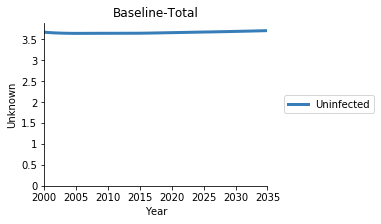

In [17]:
d = au.PlotData(par_results,pops='total',outputs=[{'Uninfected':'(sus+vac)/alive'}])
figs = au.plot_series(d)

This is obviously incorrect because the value is greater than 1. Instead, we need to specify that we are averaging across populations. However, note that because the aggregation is an arbitrary function, the units of the output quantity are unknown. Therefore, a warning is not displayed (because the code does not know what the units are).

Because the populations have very different sizes, a popsize-weighted average would be most appropriate:

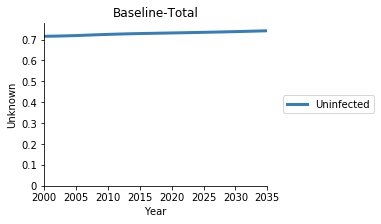

In [18]:
d = au.PlotData(par_results,pops='total',outputs=[{'Uninfected':'(sus+vac)/alive'}],pop_aggregation='weighted')
figs = au.plot_series(d)

### Axis units

One final comment regards the units of the plot data. The plotting functions will automatically display the units on the y-axis if the units for all of the data being plotted are the same. The possible units for various quantities are:

- `Compartment` : 'Number of people'
- `Characteristic` : 'Number of people' if no denominator, or '' (dimensionless) if there is a denominator
- `Parameter` : 'unknown' if not a transition parameter, otherwise 'probability', 'proportion', or 'number'
- `Link` : 'Number of people/year' if not time aggregated, 'Number of people' otherwise

The names for these units are by default derived from the names set in `model.py`.

<div class="alert alert-info">
Output aggregations will have units that match the constituent quantities if they all have the same units, or 'unknown' if they have different units or if a function aggregation is used. See examples below
</div>

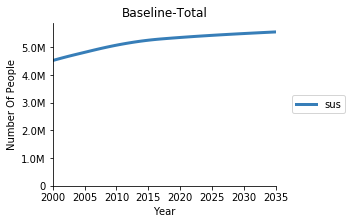

In [19]:
# Compartment units
d = au.PlotData(par_results,pops='total',outputs=['sus'])
figs = au.plot_series(d)

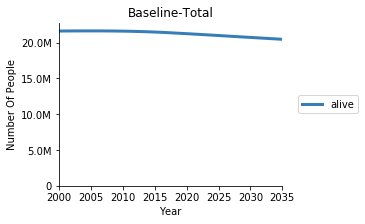

In [20]:
# Characteristic units
d = au.PlotData(par_results,pops='total',outputs=['alive'])
figs = au.plot_series(d)

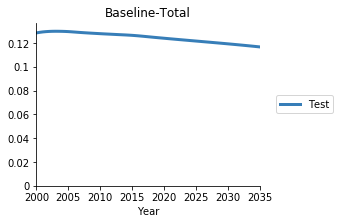

In [21]:
# Characteristic prevalance units (dimensionless)
d = au.PlotData(par_results,pops='total',output_aggregation='average',pop_aggregation='average',outputs=[{'Test':['lt_prev','spd_prev']}])
figs = au.plot_series(d)

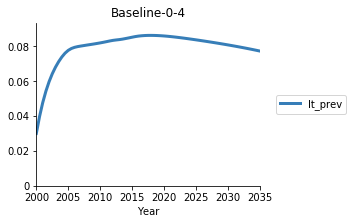

In [22]:
# Characteristic prevalance units (dimensionless)
d = au.PlotData(par_results,pops='0-4',outputs=['lt_prev'])
figs = au.plot_series(d)

In [23]:
par_results.model.pops[0].pars

[Parameter "aci_idiv" (u'0-4', u'aci_idiv'),
 Parameter "lti_idiv" (u'0-4', u'lti_idiv'),
 Parameter "ltei_idiv" (u'0-4', u'ltei_idiv'),
 Parameter "lteti_idiv" (u'0-4', u'lteti_idiv'),
 Parameter "acdi_idiv" (u'0-4', u'acdi_idiv'),
 Parameter "dti_idiv" (u'0-4', u'dti_idiv'),
 Parameter "vaci_idiv" (u'0-4', u'vaci_idiv'),
 Parameter "und_idiv" (u'0-4', u'und_idiv'),
 Parameter "p_div" (u'0-4', u'p_div'),
 Parameter "n_div" (u'0-4', u'n_div'),
 Parameter "pd_div" (u'0-4', u'pd_div'),
 Parameter "pm_div" (u'0-4', u'pm_div'),
 Parameter "px_div" (u'0-4', u'px_div'),
 Parameter "nd_div" (u'0-4', u'nd_div'),
 Parameter "nm_div" (u'0-4', u'nm_div'),
 Parameter "nx_div" (u'0-4', u'nx_div'),
 Parameter "inf_sus" (u'0-4', u'inf_sus'),
 Parameter "vac_fac" (u'0-4', u'vac_fac'),
 Parameter "lat_fac" (u'0-4', u'lat_fac'),
 Parameter "spd_infxness" (u'0-4', u'spd_infxness'),
 Parameter "sn_fac" (u'0-4', u'sn_fac'),
 Parameter "mdr_fac" (u'0-4', u'mdr_fac'),
 Parameter "xdr_fac" (u'0-4', u'xdr_fac'

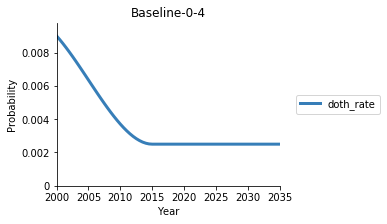

In [24]:
# Transition parameter units (probability)
d = au.PlotData(par_results,pops='0-4',outputs=['doth_rate'])
figs = au.plot_series(d)

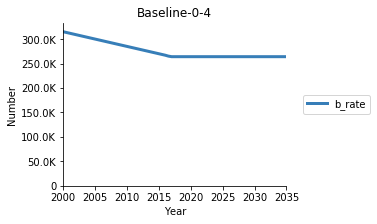

In [25]:
# Transition parameter units (number)
d = au.PlotData(par_results,pops='0-4',outputs=['b_rate'])
figs = au.plot_series(d)

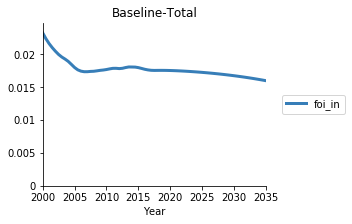

In [26]:
# Non-transition parameter units
d = au.PlotData(par_results,pops='total',outputs=['foi_in'])
figs = au.plot_series(d)

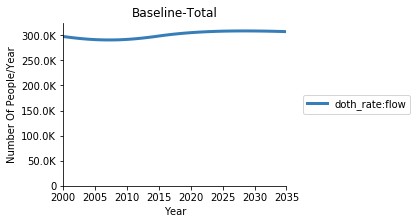

In [27]:
# Actual flow rate
d = au.PlotData(par_results,pops='total',outputs=['doth_rate:flow'])
figs = au.plot_series(d)

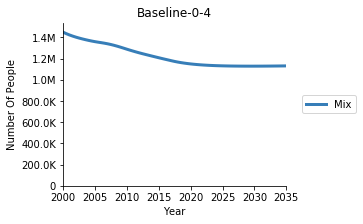

In [28]:
# Matched normal aggregation
d = au.PlotData(par_results,pops='0-4',outputs=[{'Mix':['sus','vac']}])
figs = au.plot_series(d)

Aggregation for output 'Mix' is mixing units, this is almost certainly not desired.


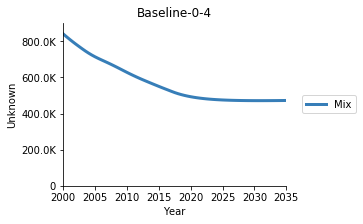

In [29]:
# Mixed normal aggregation
d = au.PlotData(par_results,pops='0-4',outputs=[{'Mix':['sus','doth_rate']}])
figs = au.plot_series(d)

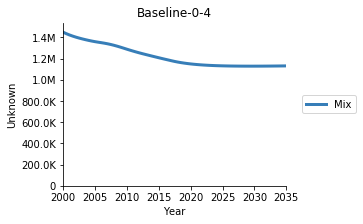

In [30]:
# Matched function aggregation - note that units are 'unknown' even though the units match
# because we aren't able to keep track of units inside the arbitrary function
d = au.PlotData(par_results,pops='0-4',outputs=[{'Mix':'sus+vac'}])
figs = au.plot_series(d)

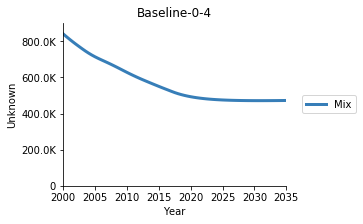

In [31]:
# Mixed function aggregation - note that no warning is displayed because the units are unknown
d = au.PlotData(par_results,pops='0-4',outputs=[{'Mix':'sus+doth_rate'}])
figs = au.plot_series(d)

<div class="alert alert-warning">
Remember that function aggregations *always* result in unknown units, even if there is only one item in the function. So for example, `outputs={'Susceptible':'sus'}` will have unknown units because the value of `'Susceptible'` in the dictionary is a string. In contrast,`outputs={'Susceptible':['sus']}` will not have unknown units, because the value `'Susceptible'` is a list, and function aggregation is not used
</div>

The units that get displayed are contained in the `Series` object within the `PlotData`. So if you know the units of the quantity, you can always set them prior to plotting:

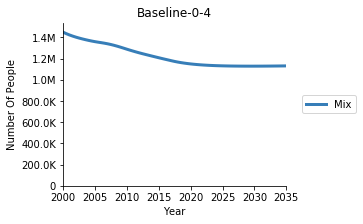

In [32]:
d = au.PlotData(par_results,pops='0-4',outputs=[{'Mix':'sus+vac'}])
d.series[0].units = 'Number of people'
figs = au.plot_series(d)

### Flow rate aggregations and disaggregations

A common task is to plot aggregations and disaggregations of flow rates. We have already seen that a transition tag can be used to refer to the aggregated set of all links sharing that tag. For instance, the parameter `doth_rate` governs 'death by other causes' and it provides values for a number of links, since most compartments have a flow into the `doth` compartment. If we plot the transition tag `doth_rate:flow` then we will be getting the entire flow associated with the parameter `doth_rate` i.e. the flow summed over all of these links.

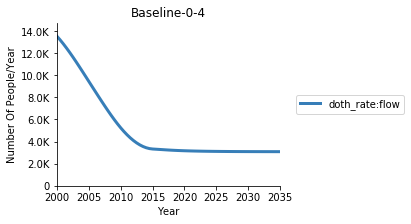

In [33]:
d = au.PlotData(par_results,pops='0-4',outputs='doth_rate:flow')
figs = au.plot_series(d)

Suppose instead we wanted to look at just one of these links, for instance, the flow from susceptible straight to death. This can be accomplished using the `:` syntax supported by `Population.get_variable`. If you have a population, in addition to getting variables based on their name, you can retrieve links by source compartment and/or destination compartment, filtered by parameter label. Supported syntax is

- `source_label:dest_label` - All links from source to destination
- `source_label:` - All links from source 
- `:dest_label` - All links to destination
- `source_label:dest_label:par_label` - All links from source to destination with given parameter label
- `source_label::par_label` - All links from source with given parameter label
- `:dest_label:par_label` - All links to destination with given parameter label

See examples below

In [34]:
#All links from 'sus' to 'doth'
par_results.model.pops[0].get_variable('sus:doth')

[Link doth_rate:flow (parameter doth_rate) - sus to doth]

In [35]:
#All links going out of 'sus' 
par_results.model.pops[0].get_variable('sus:')

[Link doth_rate:flow (parameter doth_rate) - sus to doth,
 Link e_rate:flow (parameter e_rate) - sus to emi,
 Link v_num:flow (parameter v_num) - sus to vac,
 Link l_inf:flow (parameter l_inf) - sus to lteu,
 Link age_0-4_to_5-14_sus:flow (parameter age_0-4_to_5-14) - sus to sus]

In [36]:
#All links out of 'sus' belonging to 'doth_rate'
par_results.model.pops[0].get_variable('sus::doth_rate')

[Link doth_rate:flow (parameter doth_rate) - sus to doth]

This same syntax is supporting by `PlotData`. For instance, to plot the flow from `sus` to `doth` you can specify these as the source and destination compartments, rather than providing the parameter label or transition tag. This allows you to isolate the `sus-doth` flow even though the same transition tag appears in multiple links.

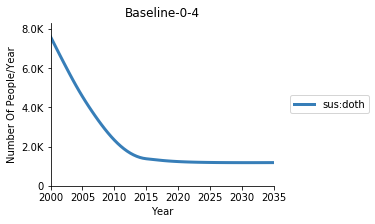

In [37]:
d = au.PlotData(par_results,pops='0-4',outputs='sus:doth')
figs = au.plot_series(d)

So, if we want to plot the disaggregated rate of death by other causes, we need to build up a list of all of the compartment pairs associated with `doth_rate` and then use them as outputs

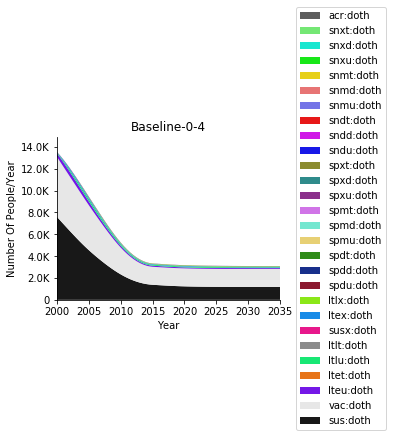

In [38]:
par = par_results.model.pops[0].get_par('doth_rate') # Get the parameter
links = ['%s:%s' % (link.source.name,link.dest.name) for link in par.links] # source:dest strings for all associated links
d = au.PlotData(par_results,pops='0-4',outputs=links)
figs = au.plot_series(d,plot_type='stacked');

## Plotting series


A number of options are available when plotting a time series. First, `PlotData` is a 4-dimensional quantity - a data point is uniquely identified based on `result`, `pop`, `output` and `time`. For a time series plot, the x-axis is always the time dimension. Then, you can select whether separate lines on the plot should be drawn for `results`, `pops`, or `outputs`, by using the `axis` argument to `plot_series`. Finally, `plot_series` will display a separate figure for each of the remaining dimensions. The example below has a `PlotData` object containing 2 results, 2 pops, and 2 outputs, and shows the effect of setting the `axis` property to each of the possible options:

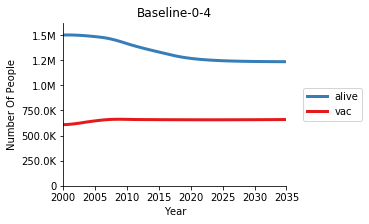

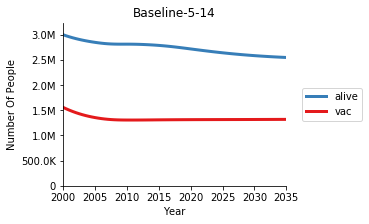

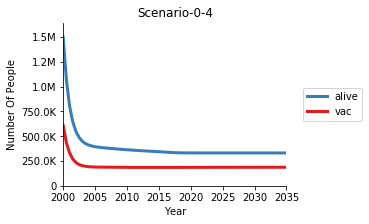

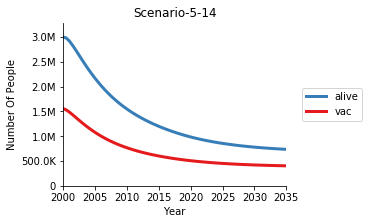

In [39]:
# Compare outputs on the plot
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['alive','vac'])
figs = au.plot_series(d,axis='outputs')

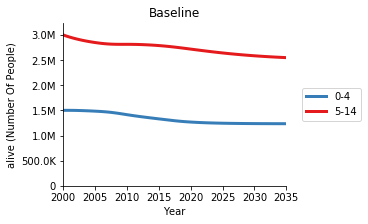

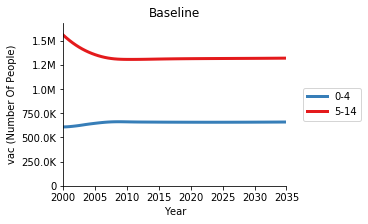

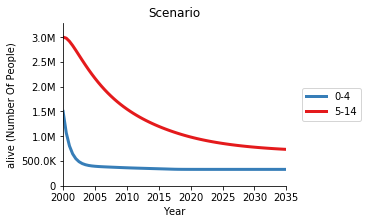

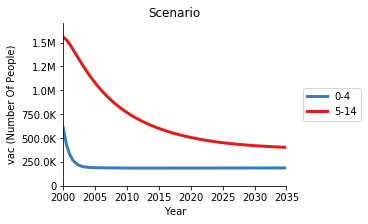

In [40]:
# Compare populations on the plot
#
# Note how we are reusing the PlotData instance (d)
# because we are only generating a different view
# of the same data
figs = au.plot_series(d,axis='pops')

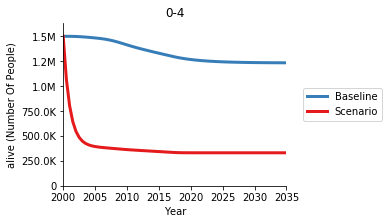

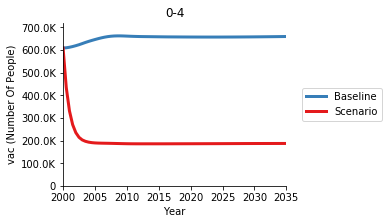

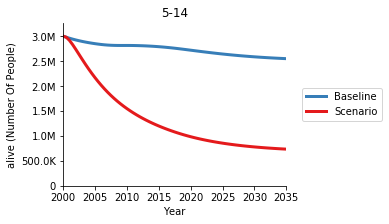

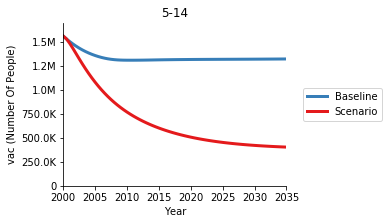

In [41]:
# Compare results on the plot (e.g. for scenarios)
figs = au.plot_series(d,axis='results')

Another common task is superimposing data on the plot. This can be done by passing a `Data` dict to `plot_series`. Typically, this is just `proj.data` . If data does not exist, then it will not be plotted.

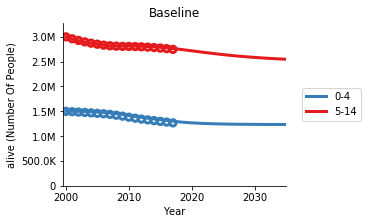

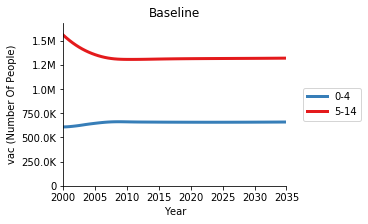

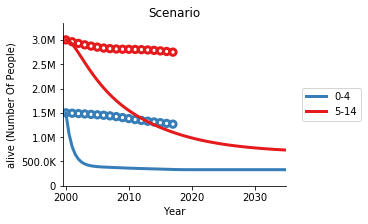

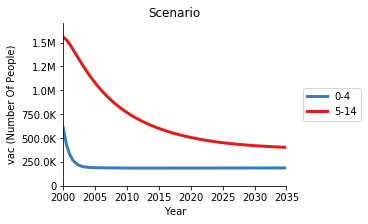

In [42]:
figs = au.plot_series(d,axis='pops',data=proj.data)

Finally, there are three types of plots

- Line plots (as shown above)
- Stacked plots
- Stacked plots, normalized to unit height (to show relative proportions)

These can be set using the `plot_type` argument

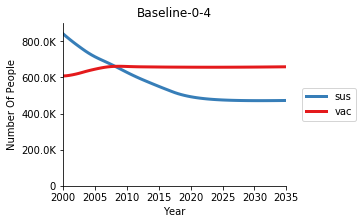

In [43]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = au.plot_series(d,plot_type='line')

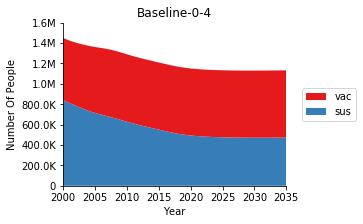

In [44]:
figs = au.plot_series(d,plot_type='stacked')

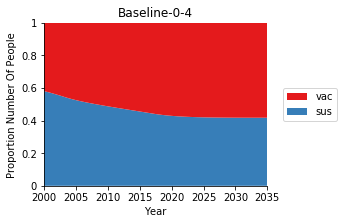

In [45]:
figs = au.plot_series(d,plot_type='proportion')

The stacking order is determined by the order that the quantities are specified when instantiating the `PlotData` object. The bottom-most color on the plot is the quantity that appears first in the list. For example

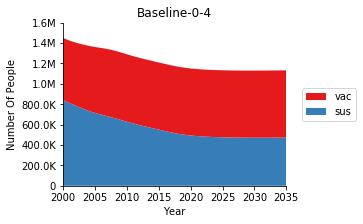

In [46]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = au.plot_series(d,plot_type='stacked')

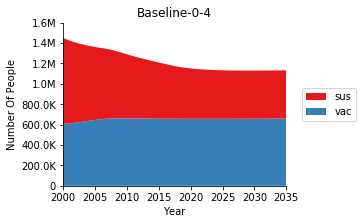

In [47]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['vac','sus'])
figs = au.plot_series(d,plot_type='stacked')

### Stacked plots and data

We have already seen above that if multiple Series are plotted and there is data associated with them, then those data will be displayed as scatter points:

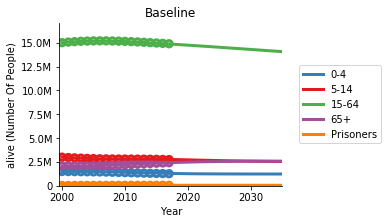

In [48]:
d = au.PlotData(par_results,outputs=['alive'])
figs = au.plot_series(d,axis='pops',plot_type='line',data=proj.data)

If you display this as a stacked plot instead, data will still be shown. The logic is that each Series is plotted above a baseline corresponding to the sum of all Series displayed below it. For example, the `15-64` population is plotted above both `(0-4)` and `(5-14)`. To render the data, the baseline value (from the model) is added to the data points prior to plotting. Thus, if the model output matches the data well, the data points will line up model output.

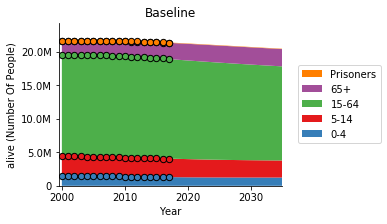

In [49]:
figs = au.plot_series(d,axis='pops',plot_type='stacked',data=proj.data)

As shown above, interpreting this plot is quite natural when the model output matches the data well, as for the healthy populations. However, in the case where the model output is not a good match, it is possible that the stacking order of the data points could appear visually incorrect. Data points should be interpreted relative to their corresponding series only. If for instance the model underestimates one of the quantities, the data points for that quantity could appear above the shaded area and data points for the next quantity in the stack. Thus, while the plotting library provides the ability to render data on top of a stacked line plot, this feature should be used carefully. 

### Plotting transition parameters and flow rates

Every transition in the model is governed by a `Link` object, which derives its value from a `Parameter`. A `Parameter` object may supply values for multiple `Links` (e.g. `doth_rate` supplies death by other causes for multiple compartments). A `Parameter` may be in units of fraction or number, while a `Link` is always in units of `number`. A `Link` can be identified by its name, which is the name of the parameter that it derives its values from, but with `':flow'` appended to the end. 

If you want to plot a `Parameter`, the `output` label should be the parameter's label, while if you want to plot an actual flow rate, then you should append `':flow'` to the name. If you specify that you are plotting links, **the values will automatically be summed over duplicate links and annualized**. In both cases, if you specify that data should be plotted, the data will be accessed based on the `Parameter` label, if the units match. This is illustrated below:

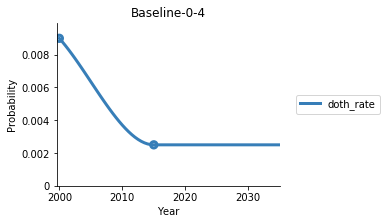

In [50]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['doth_rate'])
figs = au.plot_series(d,data=proj.data)

Here, `v_rate` is a Parameter label, so the value being plotted is for the transition parameter which here was defined in fraction units. The data points correspond to this same data.

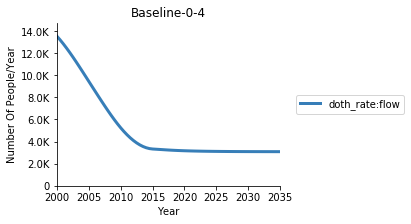

In [51]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['doth_rate:flow'])
figs = au.plot_series(d,data=proj.data)

Now, `v_rate:flow` is the transition derived from `v_rate`. Therefore, it is in units of `Number of people/year`. Note that the data points have not plotted, because the parameter is not in the same units.

### Setting full names

The `results`, `pops`, and `outputs` properties of the `PlotData` object specify both the order in which the quantities will be plotted, and the mapping between code names and full names. Most commonly, this is used to display full names from the `project` object. To use full names, pass a `project` object to the `PlotData` constructor:

#0: "Baseline": 'Baseline'
#0: "0-4": u'Children 0-4'
#0: "vac": u'Vaccinated'
#1: "sus": u'Susceptible'


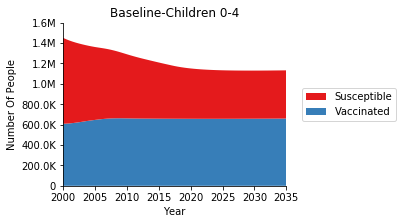

In [52]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['vac','sus'],project=proj)
print d.results
print d.pops
print d.outputs
figs = au.plot_series(d,plot_type='stacked')

Note that you can manually set labels in these dictionaries if you wish to apply any manual or additional renaming prior to plotting e.g.

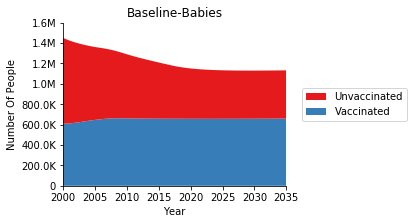

In [53]:
d.pops['0-4'] = 'Babies'
d.outputs['sus'] = 'Unvaccinated'
figs = au.plot_series(d,plot_type='stacked')

### Further formatting

In contrast to the original Optima TB plotting library, plotting and saving are separate steps. The plotting library functions return arrays containing the handles for figures that they generate. You can use these handles to interact with the plot objects prior to saving them, using any functionality provided by `matplotlib`. Some examples of figure properties you might wish to customize manually are

- Title and axis labels
- Axis ticks and tick labels
- Change marker styles, or unusual hatch patterns
- Change font sizes
- Figure size

An example is shown below

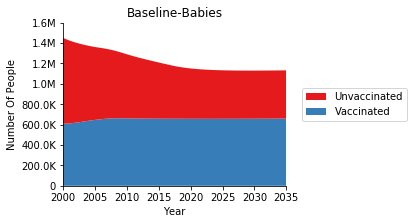

In [54]:
# Default plot
figs = au.plot_series(d,plot_type='stacked')
ax = figs[0].axes[0]

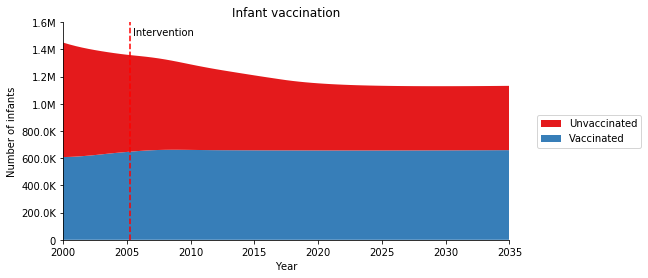

In [55]:
# Customized plot
figs = au.plot_series(d,plot_type='stacked')
figs[0].set_figwidth(10) # Change width
figs[0].set_figheight(4) # Change height
ax = figs[0].axes[0] # Retrieve the axis handle
ax.set_title('Infant vaccination'); # Set a custom title
ax.set_ylabel('Number of infants'); # Set a custom y axis label
ax.set_xticks(np.arange(2000,2040,5)); # Increase the tick frequency
ax.axvline(x=2005.25,color='r',linestyle='--'); # Highlight a particular time on the plot
ax.text(2005.5,0.94,'Intervention',transform=ax.get_xaxis_transform()); # Put a text annotation

Note that this functionality is mainly intended for figures used in presentations or reports, and so the customization commands would typically be encapsulated inside an application plotting function, rather than being something that is frequently interacted with by end users. It is suggested that this type of customization be one of the final steps in the figure production process.

Note also that because these are raw `matplotlib` commands, searching online for code snippets for how to perform common tasks in `matplotlib` (such as drawing vertical lines or text) will yield results that can be directly used.

### Module-level settings and separate legends

Similar to `matplotlib`, the Optima TB plotting library has persistent module-level settings that affect all plots. These are stored in a dict in the module:

In [56]:
import atomica.plotting as aplt
aplt.settings

{'bar_width': 1.0, 'legend_mode': 'together', 'line_width': 3.0}

Note that one of the settings is `legend_mode`. If this is set to `'separate'`, then all plots will be rendered with the legend in a separate figure. This is targeted at typical application usage where separate legends are usually all-or-none. Therefore, the `legend_mode` flag is initially set automatically when the `Project` is constructed based on the requested `plot_level` although you can change it at any time by modifying the settings. 

So for example, to make a plot with a separate legend figure, first update the settings

In [57]:
aplt.settings['legend_mode'] = 'separate'

And then make the plot

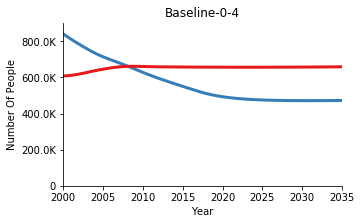

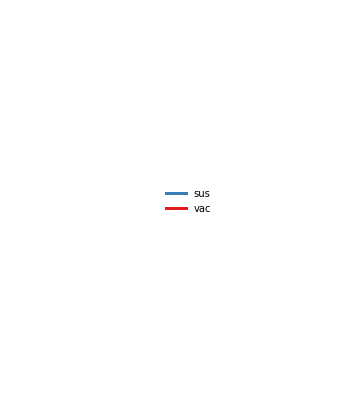

In [58]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = au.plot_series(d)

Don't forget to change the setting back, or otherwise all subsequent plots will also have their legend in a separate figure

In [59]:
aplt.settings['legend_mode'] = 'together'

You can also pass a `legend_mode` argument to `plot_series` or `plot_bars` to override the legend mode temporarily on a per-plot basis: 

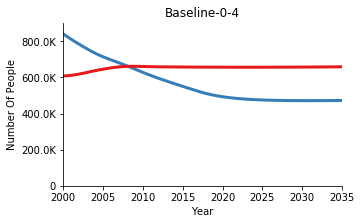

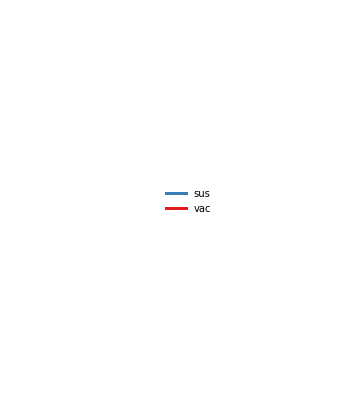

In [60]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['sus','vac'])
figs = au.plot_series(d,legend_mode='separate')

## Time accumulation

You can also sum or integrate quantities over time, for example, when calculating DALYs. This is accomplished using the `accumulate` argument to the `PlotData` constructor:

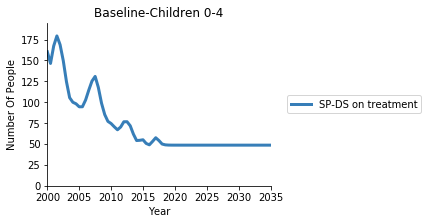

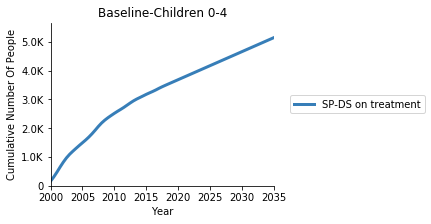

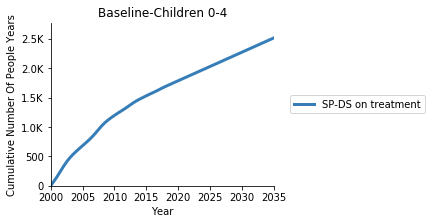

In [119]:
d = au.PlotData(par_results,pops=['0-4'],outputs='spdt',project=proj)
au.plot_series(d);
d = au.PlotData(par_results,pops=['0-4'],outputs='spdt',project=proj,accumulate='sum')
au.plot_series(d);
d = au.PlotData(par_results,pops=['0-4'],outputs='spdt',project=proj,accumulate='integrate')
au.plot_series(d);

Notice how the both accumulation methods result in the axis label changing to 'Cumulative...' but in the integration case, the units are also changed to 'people years'. Accumulation can also be performed for flow rates. However, in this case, an additional validation step is performed such that only integration is permitted. 

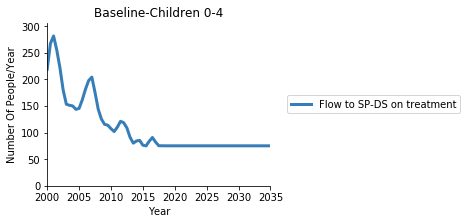

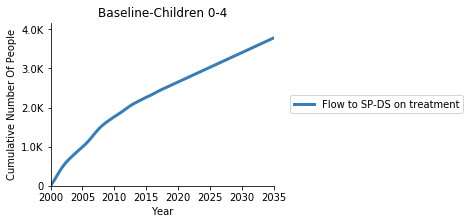

In [121]:
d = au.PlotData(par_results,pops=['0-4'],outputs=':spdt',project=proj)
au.plot_series(d);
d = au.PlotData(par_results,pops=['0-4'],outputs=':spdt',project=proj,accumulate='integrate')
au.plot_series(d);

You can use cumulative flows to count the total number of people making a transition, similar to having a sink compartment. For example, the cumulative flow into the death compartments should match the number of people in the death compartments. Of course, this is only the case because there is no outflow from the death compartments, whereas the cumulative flow could be plotted for any transition.

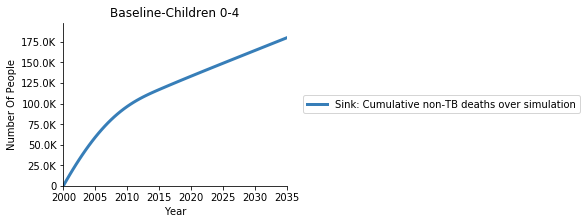

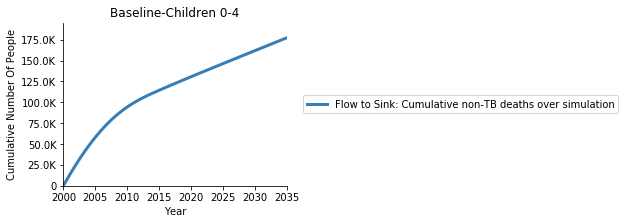

In [122]:
d = au.PlotData(par_results,pops=['0-4'],outputs='doth',project=proj)
au.plot_series(d);
d = au.PlotData(par_results,pops=['0-4'],outputs=':doth',project=proj,accumulate='integrate')
au.plot_series(d);

<div class="alert alert-info">
For consistency, time _accumulation_ takes place after time _aggregation_. That is, if you both aggregate amd accumulate a flow rate over time, it will first be integrated into a total number of people within each time period, and then can either be summed or integrated again. Accumulation by integration would produce a result in units of 'people years'. However, in general it is not anticipated that both aggregation and accumulation would be used - accumulation is most appropriate for time series plots, and aggregation is most appropriate for bar plots.
</div>

## Saving figures

A `matplotlib` figure can always be saved using `fig.savefig(fname)`. For convenience, the plotting library contains a helper function, `save_figs()` that takes in an array of figure handles. By default, the figures will be saved in the current folder, with a file name specified by the figure's `label` property. You can optionally provide a list of filenames, a prefix, and a path with a directory

In [61]:
aplt.settings['legend_mode'] = 'separate'
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['alive','vac'])
figs = au.plot_series(d,axis='pops')
au.save_figs(figs)
plt.close('all')

Saved figure "Baseline_alive.png"
Saved figure "Baseline_vac.png"
Saved figure "Scenario_alive.png"
Saved figure "Scenario_vac.png"
Saved figure "Scenario_vac_legend.png"


Notice how the key steps mentioned at the start of this document - data preparation, rendering, (customization), and saving, are reflected in the three function calls i.e.

- Data preparation: `au.PlotData()`
- Figure rendering: `au.plot_series()`
- Saving: `au.save_figs()`

Notice also how in the example above, the legend figure is automatically saved based on the last figure's name. Typically, there may be multiple plots, but only one legend. The file name for the legend is thus automatically determined based on the last figure. You can override this name by specifying the label of the figure:

In [62]:
figs = au.plot_series(d,axis='pops')
figs[-1].set_label('legend')
au.save_figs(figs)
plt.close('all')

Saved figure "Baseline_alive.png"
Saved figure "Baseline_vac.png"
Saved figure "Scenario_alive.png"
Saved figure "Scenario_vac.png"
Saved figure "legend.png"


If you specify a path, the figures will be saved inside that folder. If the folder doesn't exist, it will be created

In [63]:
figs = au.plot_series(d,axis='pops')
figs[-1].set_label('legend') # If a separate legend is requested, it is always the last figure
au.save_figs(figs,path='newfolder')
plt.close('all')

Saved figure "Baseline_alive.png"
Saved figure "Baseline_vac.png"
Saved figure "Scenario_alive.png"
Saved figure "Scenario_vac.png"
Saved figure "legend.png"


Similarly, you can specify a prefix to prepend to all figures being saved

In [64]:
figs = au.plot_series(d,axis='pops')
figs[-1].set_label('legend') # If a separate legend is requested, it is always the last figure
au.save_figs(figs,path='newfolder',prefix='example')
plt.close('all')

Saved figure "exampleBaseline_alive.png"
Saved figure "exampleBaseline_vac.png"
Saved figure "exampleScenario_alive.png"
Saved figure "exampleScenario_vac.png"
Saved figure "examplelegend.png"


Lastly, you can manually specify all of the names you want to use, overriding the default names. In that case, you don't need to set the `label` of the legend figure, because the figure name is being explicitly specified

In [65]:
figs = au.plot_series(d,axis='pops')
au.save_figs(figs,path='newfolder',prefix='series_',fnames=['a','b','c','d','e'])
plt.close('all')

Saved figure "series_a.png"
Saved figure "series_b.png"
Saved figure "series_c.png"
Saved figure "series_d.png"
Saved figure "series_e.png"


If you specify names only for the non-legend figures, the legend figure name will be automatically calculated as before

In [66]:
figs = au.plot_series(d,axis='pops')
au.save_figs(figs,path='newfolder',prefix='series_',fnames=['a','b','c','d'])
plt.close('all')
au.settings['legend_mode'] = 'together'

Saved figure "series_a.png"
Saved figure "series_b.png"
Saved figure "series_c.png"
Saved figure "series_d.png"
Saved figure "series_d_legend.png"


<div class="alert alert-warning">
In general, it is usually best not to name the legend explicitly, so that your code will be able to run regardless of the `legend_mode`, unless you are explicitly setting the `legend_mode` in your code. Also, **the intended usage is for `save_figs` to save the output of ONE call to `plot_series` or `plot_legend`. It is strongly advised not to try to save figures from multiple plotting calls in one go**. This is because changing the legend mode will change the number of figure labels that need to be provided, and thus empty strings would need to be added or removed to the list of filenames if you try to save multiple plotting call outputs with custom file names in one call to `save_figs`. It is much clearer to simply call a plottnig function, customize the plots, and save them to disk as a single unit, before calling another plotting function. 
</div>

## Plotting bars

The second primary plot type in Optima TB is the bar graph, implemented by `plot_bars`. In contrast to `plot_series`, `plot_bars` will only ever return one figure. This means that whatever data is present in the `PlotData` object will be displayed in the figure. As mentioned before, `PlotData` is 4 dimensional. In `plot_bars`, these dimensions are represented in the following ways:

- Outputs and Populations are shown as bars, that are distinguished by colour, and appear immediately adjacent to each other. For a single result and time, these output/population bars are referred to as a 'block'
- Results and Times are shown by grouping the bars. The 'inner group' corresponds to which blocks appear next to each other, while the 'outer' group specifies how the blocks are grouped

Understanding this concept is crucial to being able to work with `plot_bars`, so the examples below should be studied carefully. 

### Time aggregation

First, unlike with `plot_series`, it is typically necessary to aggregate plot data over time. This is achieved specifying the time binds when constructing the `PlotData` object. The time bins are specified as either a vector of bin edges, as a scalar spacing between bins, or the keyword `'all'` which includes all time points. So for example, if we want to aggregate the data into decade bins, we could use

In [67]:
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac'],t_bins=10)
d.series[0].t_labels

['2000-2010', '2010-2020', '2020-2030']

Alternatively, we might want to aggregate over all time points

In [68]:
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac'],t_bins='all')
d.series[0].vals

array([46344736.64990773])

Or manually specify 5 year bins

In [69]:
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac'],t_bins=np.arange(2005,2045,5))
d.series[0].vals

array([6570944.75602622, 6592197.57444016, 6574155.24141975,
       6568051.72979095, 6571079.37022623, 6582864.93636449,
                    nan])

The above example illustrates a key aspect of time aggregation - consistent with all other Python functions, the time aggregation includes times `>=` the lower value, and `<` the upper value. So for example, if the data contains time points

    t = [2000,2000.25,2000.50,2000.75,2001]

Then a time bin `[2000 2001]` would aggregate the first 4 values, but not include `t=2001`. For a typical model run with integer start and finish years, this means that the last data point would typically not be included, because it corresponds to only a partial year. If a bin extends to times before or after the simulation, then the series value will be set to `nan` to reflect the fact that data did not exist for part of the requested bin. 

However, consistent with Python behaviour, if you use `np.arange(2005,2040,5)` then the upper value `2040` will not appear in the resulting range. Thus, if you specify the upper bound as the end of the time series, and the time span is an integer multiple of the bin size, then the final bin will not be created. For instance, the simulation performed here goes from `2000-2035` so

- `np.arange(2005,2035,5) = array([2005, 2010, 2015, 2020, 2025, 2030])` so the last bin, from `2030-2035` is missing
- `np.arange(2005,2040,5) = array([2005, 2010, 2015, 2020, 2025, 2030, 2035])` so the last bin is correct
- `np.arange(2005,2045,5) = array([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040])` so the final bin is out of bounds

If you simply specify the bin size, e.g. `t_bins = 5` then the middle example will automatically be used. 

<div class="alert alert-info">
In general, it is easiest to only specify the bin width, as long as you are happy for the bins to start from the first simulation year
</div>

Finally, note that because time aggregation is implemented by `PlotData`, you can apply time aggregation to `plot_series` as well as `plot_bars` e.g. if you want to plot actual annual values.

So, to make our bar graph, we first select the results, pops, and outputs using the `PlotData` constructor, then perform any necessary time aggregation, and finally render the plot using `plotBars`:

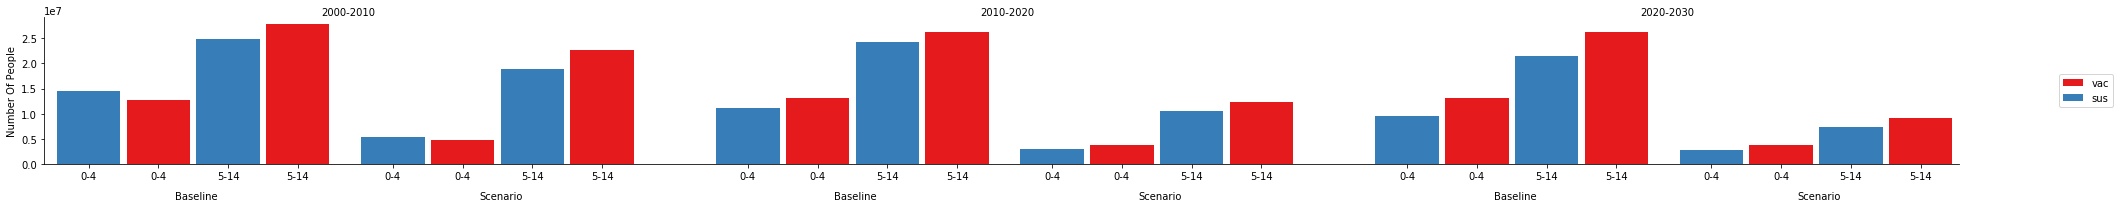

In [70]:
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac'],t_bins=10) # Select data
figs = au.plot_bars(d)

The example above illustrates the difference between the 'block', the 'inner group' and the 'outer group'

- The blocks consist of the pops and outputs - the 4 coloured bars correspond to a block
- The 'inner group' is the first level of groupings of the blocks, and the labels for the inner group appear below the plot. The inner groups here are 'Parset' and 'Progset', the names of the results
- The 'outer group' is the higher level of grouping, corresponding to groups-of-inner-groups. The name of the outer group is displayed at the top of the plot. Here, the outer group corresponds to time

You can set the outer group using the `outer` argument, which can be either `'times'` (which is the default), or `'results'`. So to use the results as the outer group, we can use:

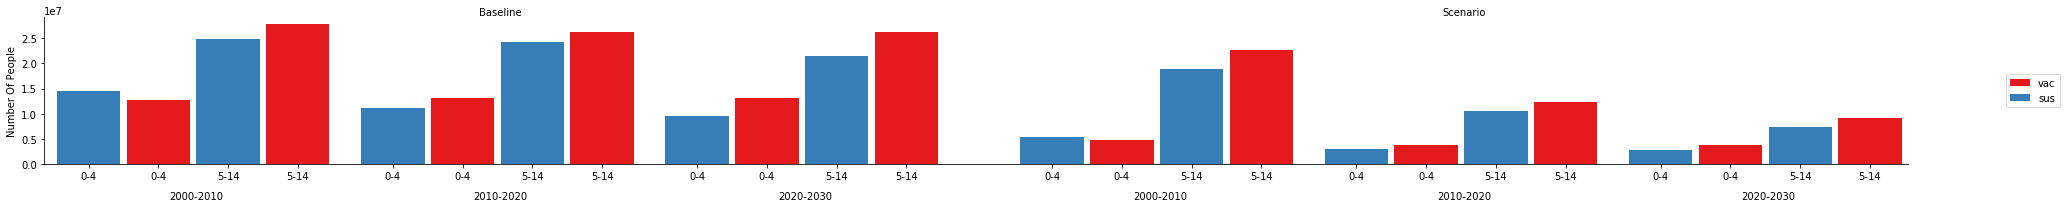

In [71]:
figs = au.plot_bars(d,outer='results')

Notice how the labels above and below the graph are now swapped.



### Stacking bars

Next, we often wish to stack quantities above and below each other. To specify these stackings, you can set the `stack_pops` and `stack_outputs` arguments to `plotBars`. By default, these are lists of all of the pops and outputs in the `PlotData` object. If you want quantities to appear in the same bar, you can specify a list containing the names of the pops and outputs that should appear in the same bar. Two examples are shown below:

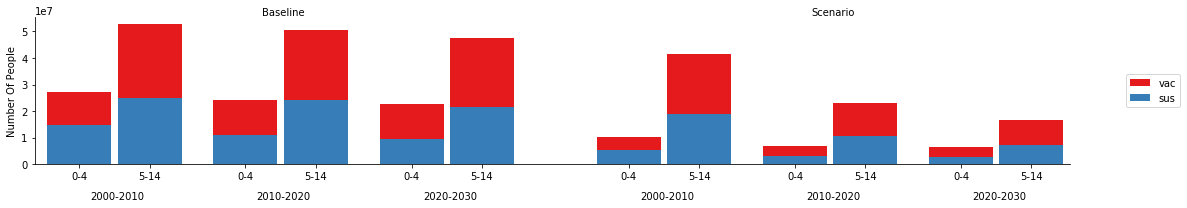

In [72]:
# Stack outputs, to compare population sizes, with a colour breakdown of the vaccination state
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','vac']])

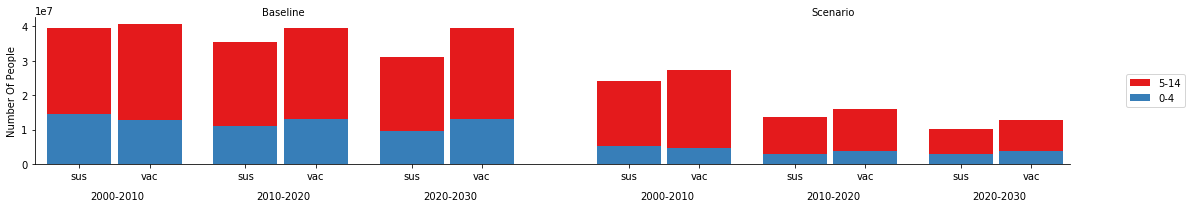

In [73]:
# Stack pops, to compare vaccination states, with a colour breakdown per population
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']])

If you specify a partial list of stackings, then any pops or outputs that do not appear in the stack will automatically be added as separate unstacked bars. For example, if we have

In [74]:
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=10)

Then setting `stack_outputs = [['sus','vac']]` is equivalent to `stack_outputs = [['sus','vac'],'lt_inf']`

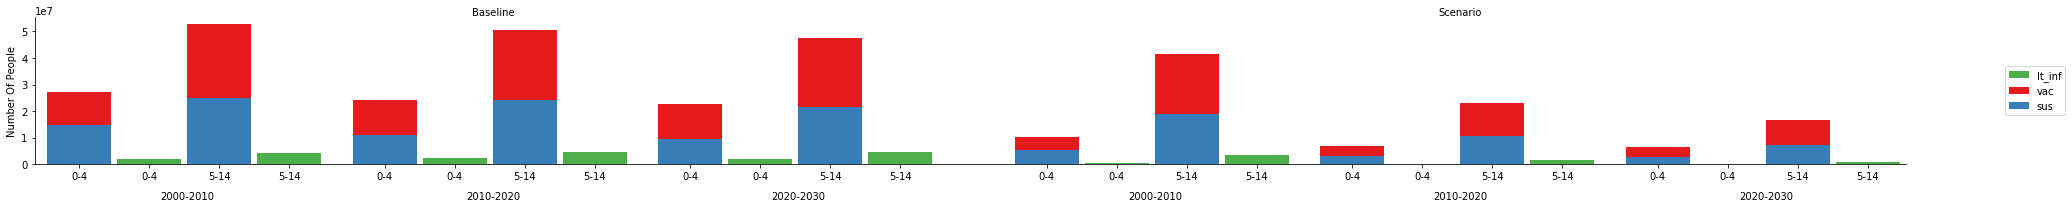

In [75]:
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','vac']])

You can specify an output multiple times if you want it to appear in more than one stack

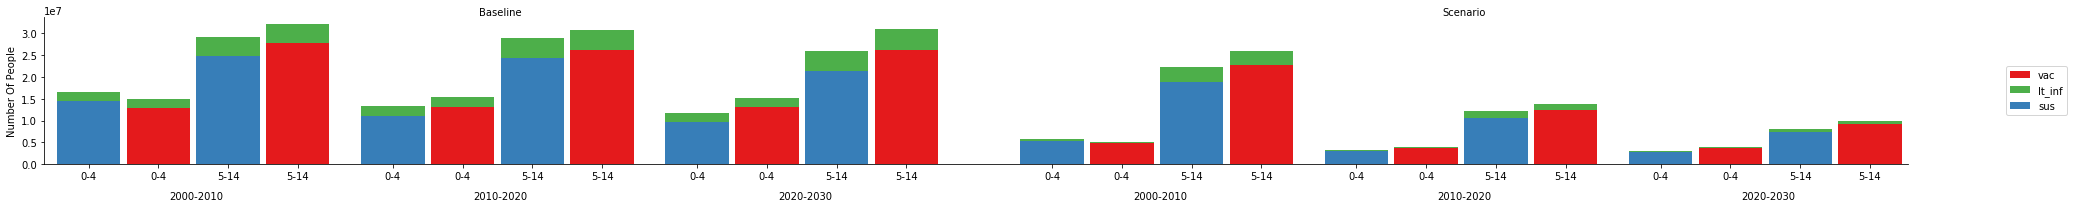

In [76]:
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

The stacking order is the same as the order of the list that you use to specify the stacks:

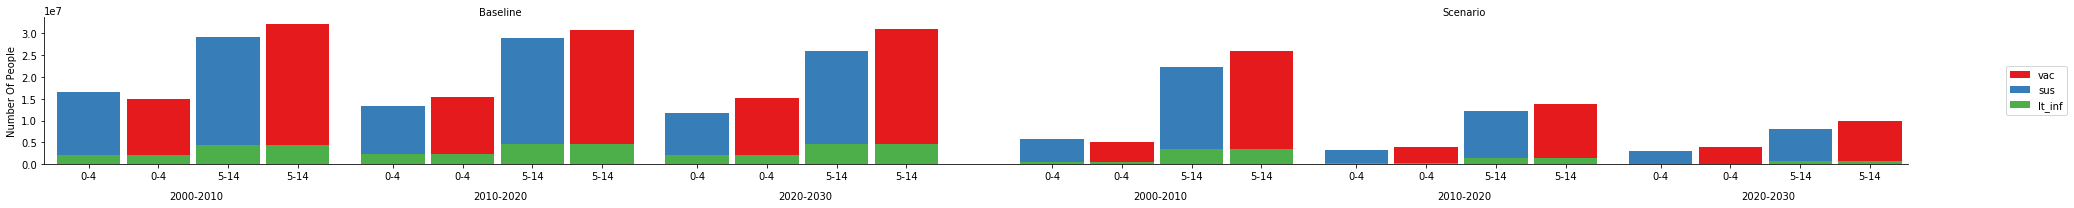

In [77]:
figs = au.plot_bars(d,outer='results',stack_outputs=[['lt_inf','sus'],['lt_inf','vac']])

You can also specify multiple levels of stacking, although be aware that this can potentially make the plot difficult to read

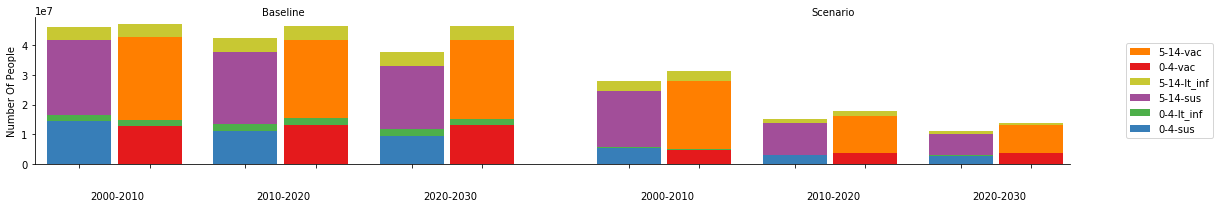

In [78]:
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=10)
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

Notice how the legend text automatically changes depending on the stacking. However, if you stack both pops and outputs, then there won't be any text labelling the bars within a block.

Finally, if you want to stack all of the items of a given type, you can specify `all` instead of a list of quantities to stack:

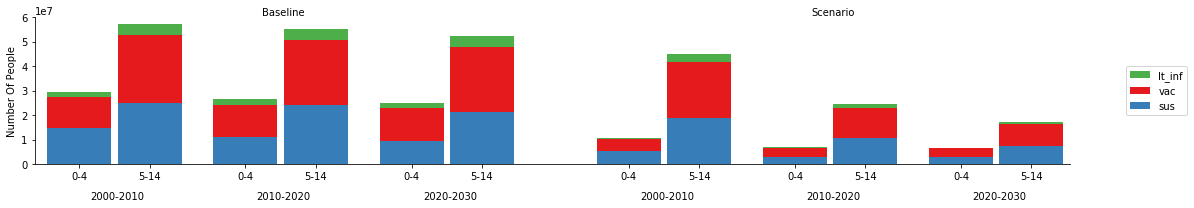

In [79]:
figs = au.plot_bars(d,outer='results',stack_outputs='all')

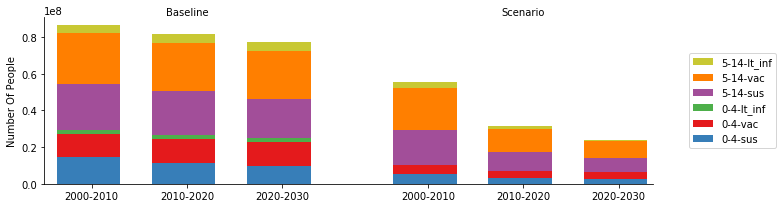

In [80]:
figs = au.plot_bars(d,outer='results',stack_outputs='all',stack_pops='all')

#### Stacking vs. Aggregation

An _aggregation_ maps multiple time series onto a single quantity, while _stacking_ puts two quantities in the same bar. A general rule of thumb is that an _aggregation_ should be used if you want the two quantities to share the same colour, while _stacking_ should be used if the quantities need to be visually disaggregated.

### Horizontal bars

To make a horizontal bar plot, use the optional `orientation` argument. Set it to `'horizontal'` for horizontal bars, or `'vertical'` for normal vertical bars (this is the default). All stacking and grouping functionality functions as normal.

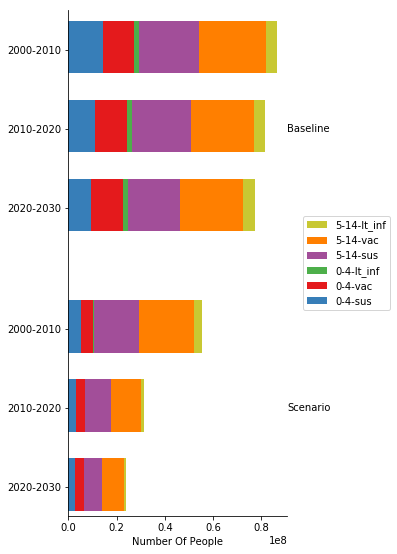

In [81]:
figs = au.plot_bars(d,outer='results',stack_outputs='all',stack_pops='all',orientation='horizontal')

### Labelling bars

When specifying stacks of bars, you can alternatively specify a `dict` where the key is the name you want to use for that stack. Then, that name will be used for the appropriate bars

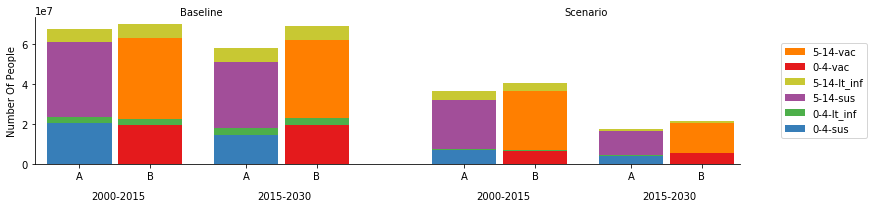

In [82]:
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=15)
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs={'A':['sus','lt_inf'],'B':['vac','lt_inf']})

The logic for the labelling is divided into two streams - a stream if you specify any user labels (by specifying the output and/or pop stacks using a `dict`) or a stream if the labels are to be determined automatically.

In the automatic stream
- Each bar is assigned a pop label and an output label based on which items are stacked in that bar. The label is empty if more than one item is stacked. 
- The colour scheme will be automatically determined based on whether pops, outputs, or both are stacked
- If the colour scheme separates outputs, then the bars will be labelled by population, and vice-versa
- If all of the bars have the same name, then that name will be automatically suppressed

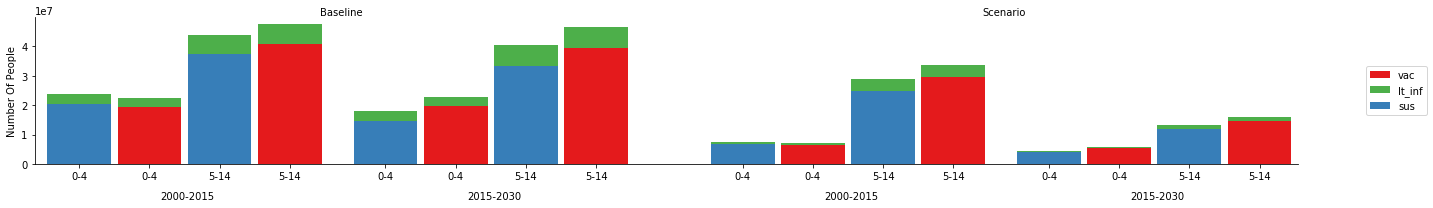

In [83]:
# Stack only outputs, bars labelled using pops
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=15)
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

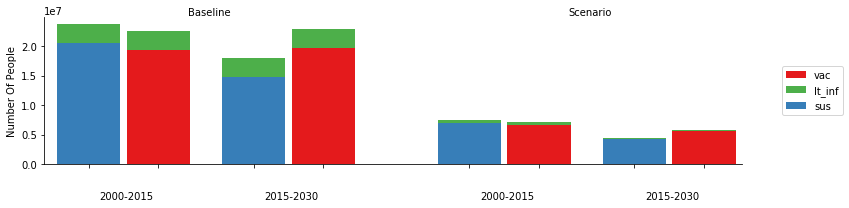

In [84]:
# Stack only outputs, only one pop so no bar label
d = au.PlotData([par_results,scen_results],pops=['0-4'],outputs=['sus','vac','lt_inf'],t_bins=15)
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

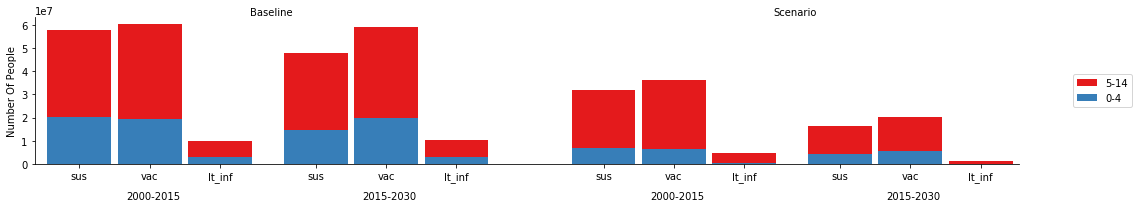

In [85]:
# Stack only pops, bars labelled by output
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=15)
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']])

For user specified labels
- A user specified label will always be printed
- If you specify only the output labels, and there is more than one automatic pop label, then the pop labels will be shown. And vice-versa if you specify only the pop labels

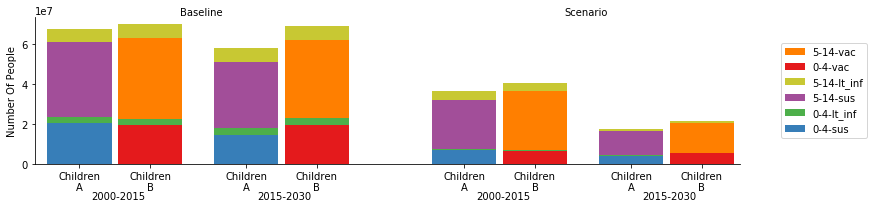

In [86]:
# Specifying both output and pop names - both names are shown
figs = au.plot_bars(d,outer='results',stack_pops={'Children':['0-4','5-14']},stack_outputs={'A':['sus','lt_inf'],'B':['vac','lt_inf']})

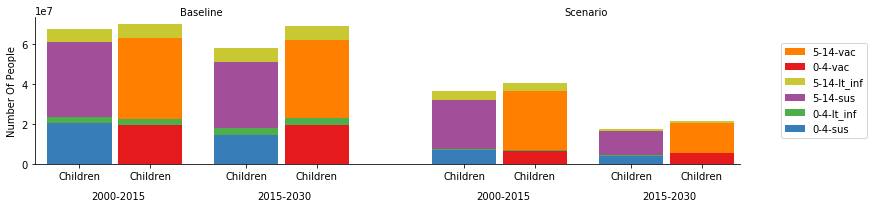

In [87]:
# Specifying only pops - because outputs are stacked, there is no automatic label, so no output labels are shown
figs = au.plot_bars(d,outer='results',stack_pops={'Children':['0-4','5-14']},stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

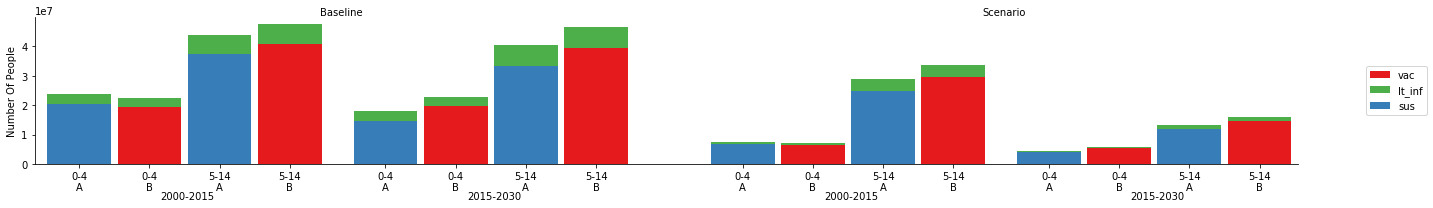

In [88]:
# Specifying output stack names - because pops are not stacked, there is an automatic pop label which is shown
figs = au.plot_bars(d,outer='results',stack_outputs={'A':['sus','lt_inf'],'B':['vac','lt_inf']})

If you want to set custom labels for _every_ bar, then you can set the `xlabels` for the plot after rendering

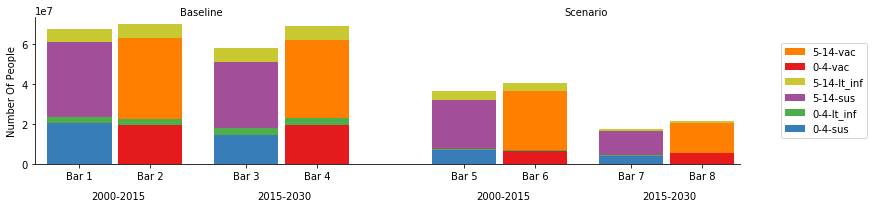

In [89]:
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
ax = figs[0].axes[0]
ax.set_xticklabels(['Bar 1','Bar 2','Bar 3','Bar 4','Bar 5','Bar 6','Bar 7','Bar 8']);

## Working with legends

### Controlling legend order

By default, the legend order will be determined by the internal plotting order, so it is largely dependent on the order in which you specify the variables. For bar graphs and stacked/proportion series, the legend order is reversed so that the legend matches the visual stacking order. However, in cases where there are complex stacks, like the one above, you might want to have the legend displayed in a different order. To support this, you can use the `reorder_legend` function. This function operates in two ways. First, you can request that the existing order is reversed:

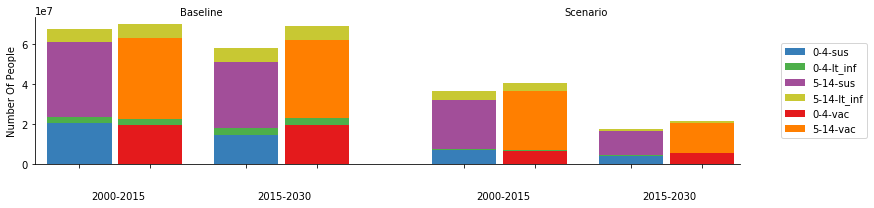

In [90]:
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
au.reorder_legend(figs[0],'reverse')

Notice how the order of the legend is exactly reversed compared to the original plot. However, you might want a more complex reordering e.g. to have the populations appear together in the legend. To achieve this, you can explicitly specify a new ordering for the legend. The input argument is a list, where the index represents the new legend order, and the value indicates the original position. For example, the original plot had the items in the order `[5-14-vac,0-4-vac,5-14-lt_inf,5-14-sus,0-4-lt_inf,0-4-sus]`. If we want the new order to be `[0-4-sus,0-4-vac,0-4-lt_inf,5-14-vac,5-14-sus,5-14-lt_inf]` then we need to specify a list with the original indices of those labels. The first item in that list would be 5, because we want `0-4-sus` to appear first, and its index in the original order was 5. You will need to render and examine the plot first to determine the original index order. So the final order list would be `[5,1,4,3,0,2]` 

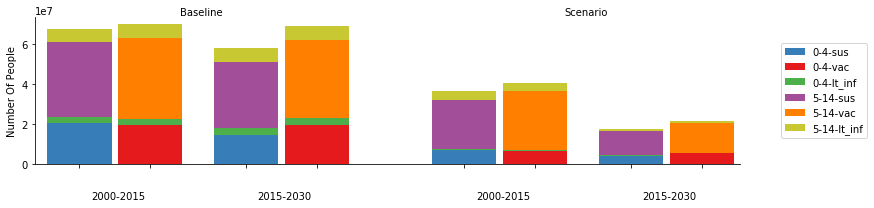

In [91]:
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
au.reorder_legend(figs[0],[5,1,4,3,0,2])

Lastly, you can use the ordering to remove items from the legend by specifying only a partial list

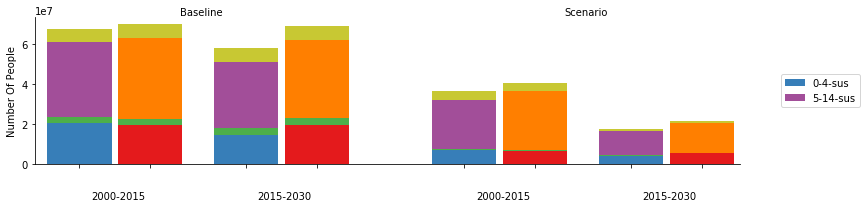

In [92]:
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
au.reorder_legend(figs[0],[5,3])

### Relabeling legend entries



The legend labels are automatically computed. However, you might want to change the legend labels after the fact. To do this, you can use the `relabel_legend` function. This function has two usages. First, if you want to change all labels, you can specify a list of label names the same length as the number of legend items, and they will be applied in order. For example

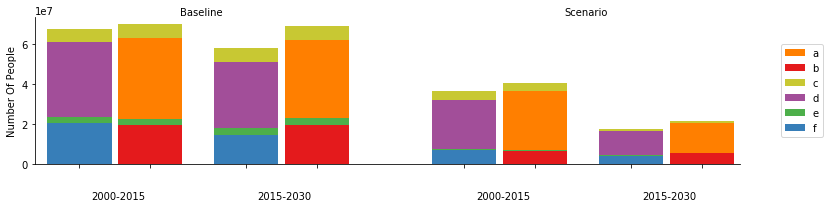

In [93]:
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
au.relabel_legend(figs[0],['a','b','c','d','e','f'])

Alternatively, you can specify a dict where the key is the index of the label you want to change, and the value is the new label name

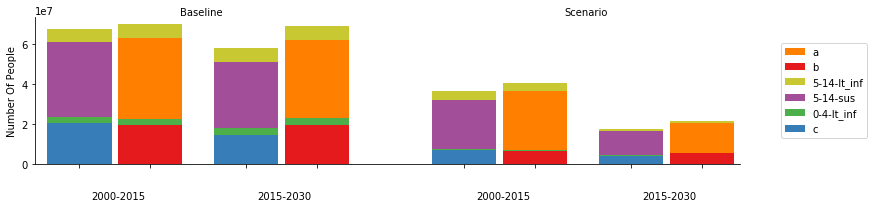

In [94]:
figs = au.plot_bars(d,outer='results',stack_pops=[['0-4','5-14']],stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])
au.relabel_legend(figs[0],{0:'a',1:'b',5:'c'})

### Making a new legend

<div class='alert alert-danger'>
These functions are out of date due to changes in legends
</div>

If you require even more customization, you can manually specify a separate legend figure to draw. The input should be an `odict` (or `dict`) where the key is the item colour and the value is the label. The reason that while it is undesirable for two different labels to have the same colour, this is still a possible valid legend, but it is not permitted for the same label to be associated with two different colours. Thus the use of the label as the key enforces that each label is only associated with one colour. 

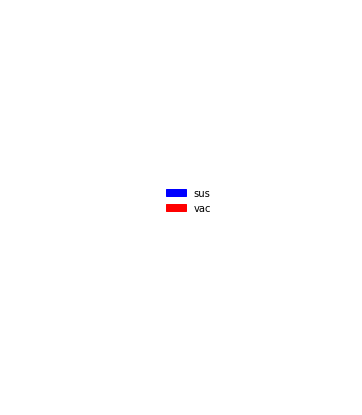

In [95]:
entries = sc.odict()
entries['sus'] = 'blue'
entries['vac'] = 'red'
au.plot_legend(entries);

The items are rendered from top to bottom in the order of `entries.keys()` so if you reorder the items, the legend will change accordingly. Similarly, if you pass in a `dict` instead of an `odict`, the order of the items will be arbitrary.

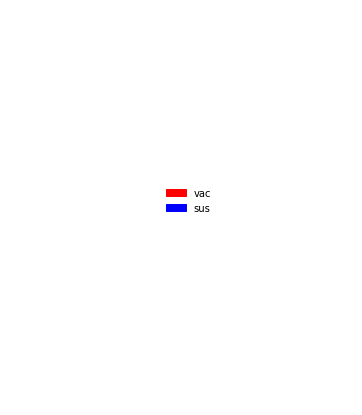

In [96]:
entries = sc.odict()
entries['vac'] = 'red'
entries['sus'] = 'blue'
au.plot_legend(entries);

`plot_legend` optionally takes in the type of legend being made (patch or line). So if the legend is intended for use with a line plot, you could use:

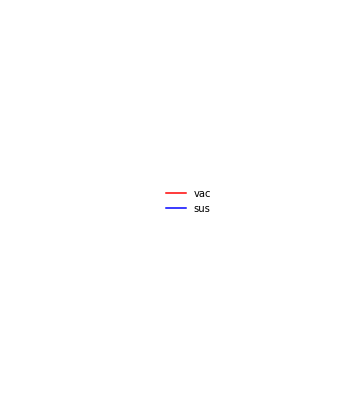

In [97]:
au.plot_legend(entries,plot_type='line');

`plot_legend` can also optionally take in the handle to an existing figure. In that case, any existing legend will be replaced, as per the examples below

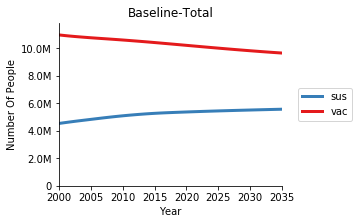

In [98]:
# Original figure
d = au.PlotData(par_results,pops='total',outputs=['sus','vac'])
figs = au.plot_series(d);

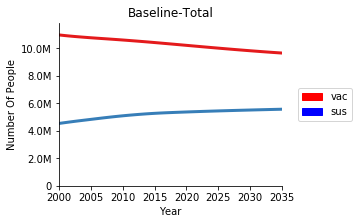

In [99]:
# Replacing the legend in the same legend figure
figs = au.plot_series(d);
au.plot_legend(entries,plot_type='patch',fig=figs[0]);

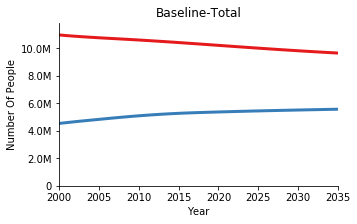

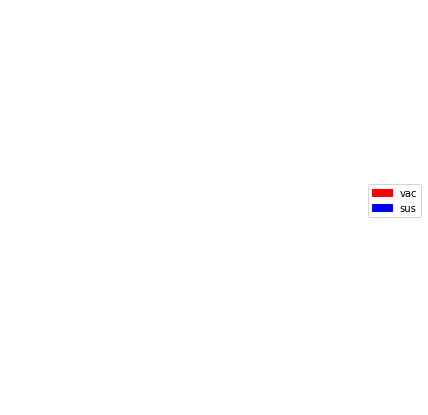

In [100]:
# Replacing the legend in a separate legend figure
figs = au.plot_series(d,legend_mode='separate');
au.plot_legend(entries,plot_type='patch',fig=figs[-1]);

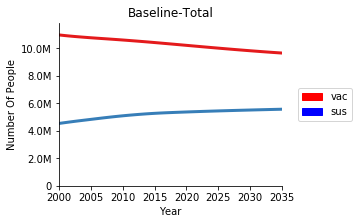

In [101]:
# Adding a legend to a figure without any legend at all
figs = au.plot_series(d,legend_mode='none');
au.plot_legend(entries,plot_type='patch',fig=figs[0]);

### Time aggregation of flow rates

Flow rates are computed every timestep, but are normally annualized for plotting. For instance, the plot below of the vaccination rate has units 'Number of people/year'

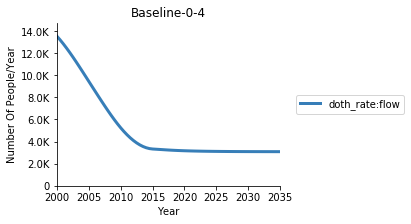

In [102]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['doth_rate:flow'])
au.plot_series(d);

However, if we apply a time aggregation, we are typically interested in the number of people transitioning over a period of time. Therefore, we do not want the flow rate to be annualized. If you specify a time aggregation, flow rate annualization is automatically disabled:

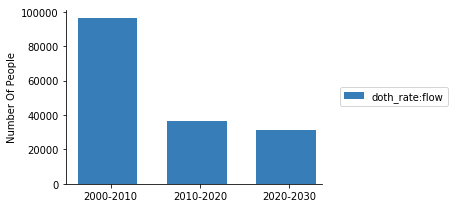

In [103]:
d = au.PlotData(par_results,pops=['0-4'],outputs=['doth_rate:flow'],t_bins=10)
au.plot_bars(d,outer='results');

<div class="alert alert-info">
Note how the plot axis y-label now shows units of 'Number of people' rather than 'Number of people/year'. 
</div>

In particular, note how the flow rate in the line plot is about 200000 people/year between 2020 and 2030. Thus the expected number of people transitioning in the decade from 2020-2030 would be `200000*10=2e6`, and we confirm that the bar graph shows approximately 2 million people have transitioned in that time period.

Lastly, note that if you make a line plot of time-aggregated data, the units will correspond to the time aggregated values, so flow rates will *not* be annualized e.g.

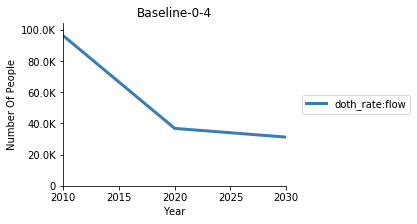

In [104]:
au.plot_series(d);

Again, note that the y-axis label changes to indicate this.

## Setting colors

A common task is to set colours. This is done by assigning colours to `Series` in the `PlotData` object. These colours are then used by `plot_series` and `plot_bars`. Colours can be assigned in two ways

- You can set the `color` property of a series, which specifies a colour for a `[results,pop,output]` item
- You can use `PlotData.set_colors()` which lets you set colors for a set of series, such that the color is shared across the other dimensions. For example, you could set a color scheme for `outputs` that is shared across all `results` and `pops`

Setting colours directly via the `color` is typically cumbersome unless automated:

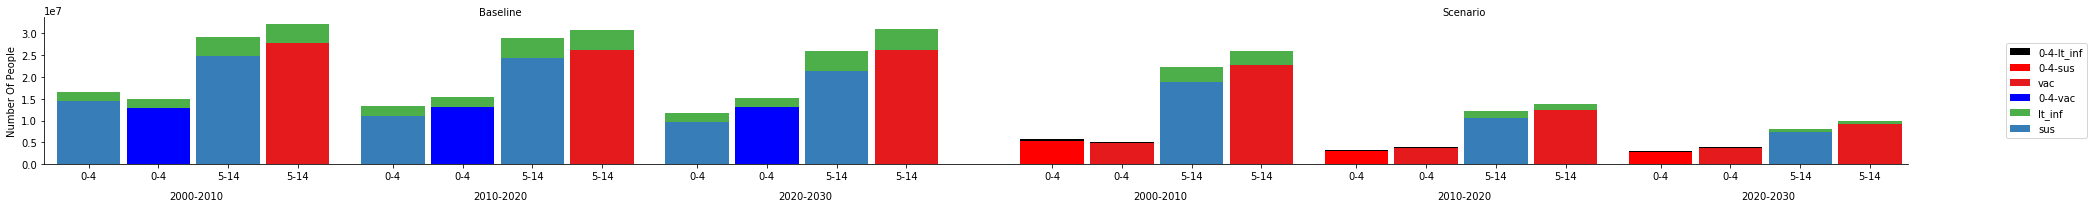

In [105]:
d = au.PlotData([par_results,scen_results],pops=['0-4','5-14'],outputs=['sus','vac','lt_inf'],t_bins=10)
d['Baseline','0-4','vac'].color = 'b'
d['Scenario','0-4','sus'].color = 'r'
d['Scenario','0-4','lt_inf'].color = 'k'
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

More typically, you would want to set colours for every instance of a result, pop, or output, across all other variables. For instance, you might want to set all of the outputs to the same colour, irrespective of result or pop. This can be done using the `set_colors` method of `PlotData`. You specify a set of filters for `result`, `pop`, and `output`, and a single color or list of colours to apply to the set of `Series` matching the filter. This filtering is best illustrated with some examples.

One important factor to be aware of is that `set_colors` has an optional argument, `overwrite`, which decides whether to preserve manually set colors or not. In the example above, colours were only specified for 3 series. The remaining colours were assigned within `plotBars`. By default, the colour of a series is `None` which means it will be automatically determined when plotted. By default, `set_colors` will only update the colours if the series colour is `None`. 



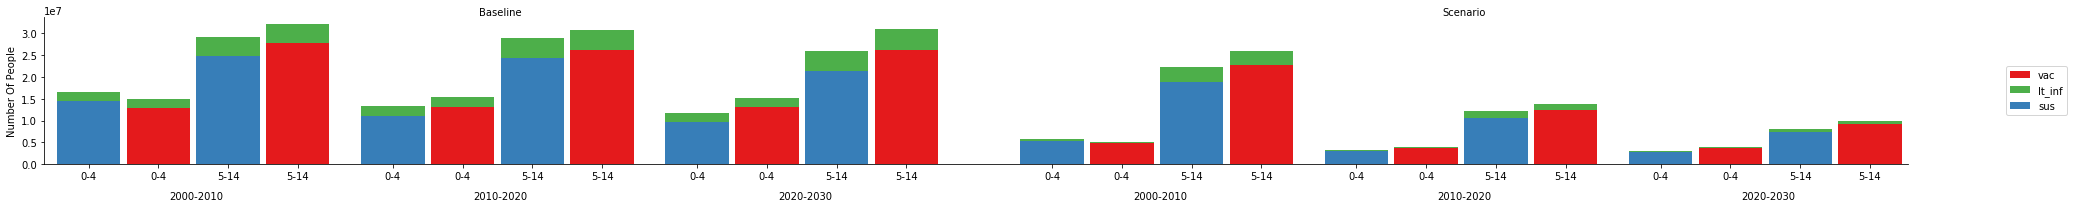

In [106]:
d.set_colors(outputs=d.outputs,overwrite=True) # Set automatic colours on a per-output basis
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

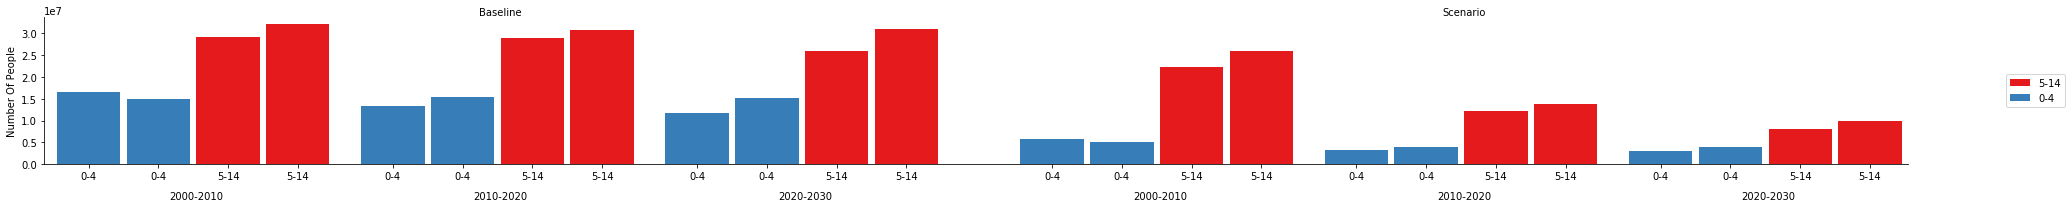

In [107]:
d.set_colors(pops=d.pops,overwrite=True) # Set automatic colours on a per-population basis
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

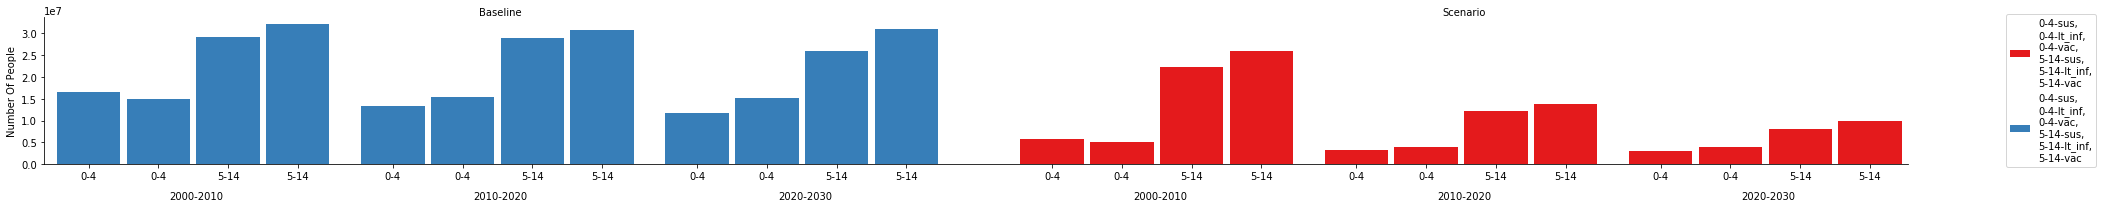

In [108]:
d.set_colors(results=d.results,overwrite=True) # Set automatic colours on a per-result basis
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

Notice how the legend automatically groups quantities that share the same colour, rather than repeatedly showing the same color separately for each quantity.

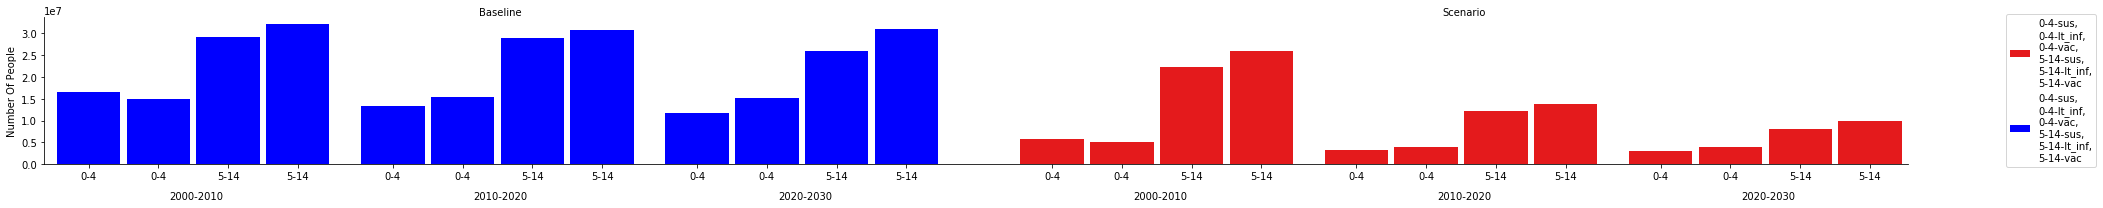

In [109]:
# Filter based only on result
d.set_colors('b',results=['Baseline'],overwrite=True) # Set all bars in 'Parset' to blue
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

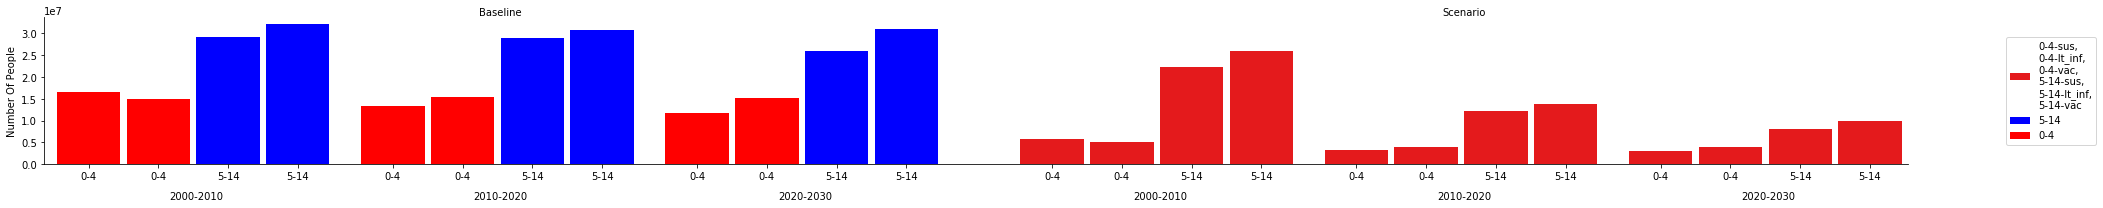

In [110]:
# Filter based on both result and pops
d.set_colors('r',results=['Baseline'],pops=['0-4'],overwrite=True) # Set all bars in 'Parset' to blue
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

If your filter matches more than one quantity, and the colour is either the name of a colormap or a list of colours, then colours from that set will be distributed and assigned to the specified items. For example

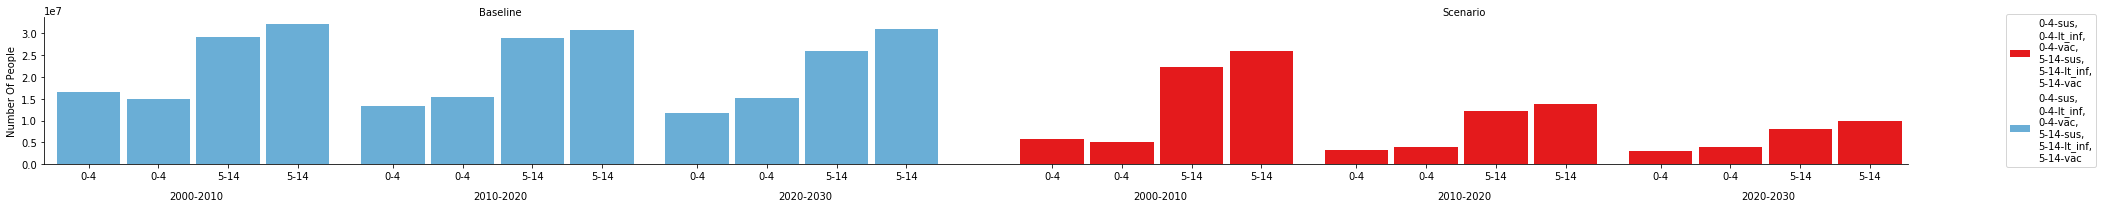

In [111]:
# Only one result is specified, so only one colour will be used
d.set_colors('Blues',results=['Baseline'],overwrite=True) # Set all bars in 'Parset' to blue
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

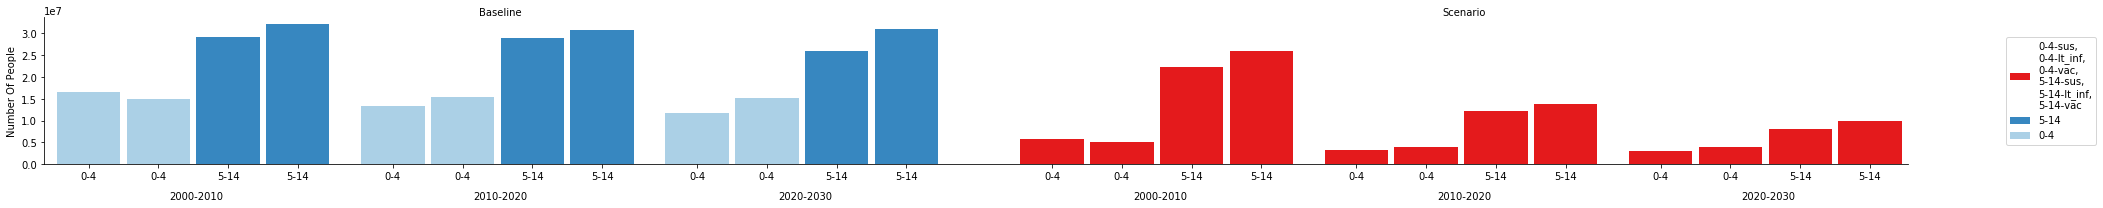

In [112]:
# 1 result and 2 pops are specified, so 1x2=2 colours will be used
d.set_colors('Blues',results=['Baseline'],pops=d.pops,overwrite=True) # Set all bars in 'Parset' to blue
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

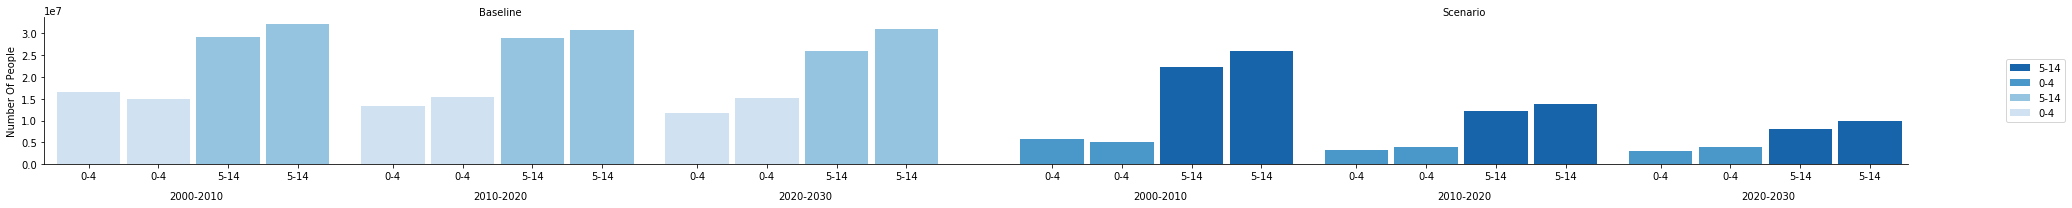

In [113]:
# 2 results and 2 pops are specified, so 2x2=4 colours will be used
d.set_colors('Blues',results=d.results,pops=d.pops,overwrite=True) # Set all bars in 'Parset' to blue
figs = au.plot_bars(d,outer='results',stack_outputs=[['sus','lt_inf'],['vac','lt_inf']])

Note that you can call `set_colors` multiple times on different subsets of the `series` to build up a complex colour scheme. This can be especially useful if you have a complex stacking arrangement. Suppose we wanted to break down the vaccination status of each population, for all populations, at three points in time. We would accomplish this as follows

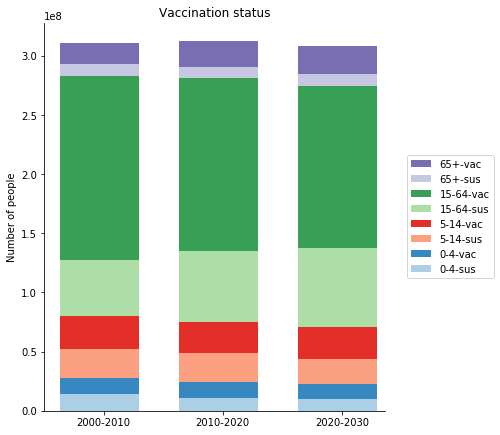

In [114]:
d = au.PlotData(par_results,pops=['0-4','5-14','15-64','65+'],outputs=['sus','vac'],t_bins=10) # Retrieve all of the data
d.set_colors('Blues',pops=['0-4'],outputs=d.outputs) # Set a colour scheme for 0-4 but still separating vac and sus
d.set_colors('Reds',pops=['5-14'],outputs=d.outputs) # Use a different colour scheme for 5-14 
d.set_colors('Greens',pops=['15-64'],outputs=d.outputs)
d.set_colors('Purples',pops=['65+'],outputs=d.outputs)
figs = au.plot_bars(d,stack_pops='all',stack_outputs='all',outer='results')
# Perform some additional post-plotting customization
figs[0].set_figwidth(7)
figs[0].set_figheight(7)
ax = figs[0].axes[0]
ax.set_title('Vaccination status');
ax.set_ylabel('Number of people');

Note that if there are no block labels and the number of inner group labels is the same as the number of bars, then the inner group labels will be 'promoted' to axis tick labels. This will not happen:

- For outer group labels
- If any block labels are specified

Lastly, note that this colour system also applies to `plot_series`, and because the colours are stored in `PlotData` they are automatically applied if you use `plot_series` to view the data:

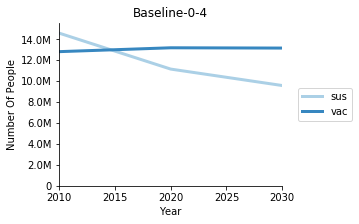

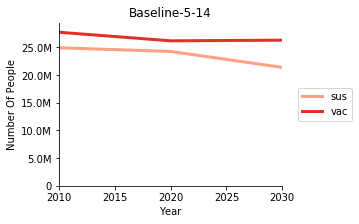

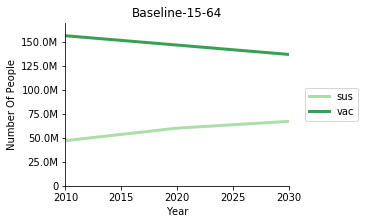

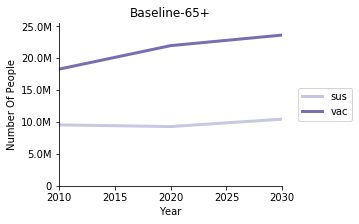

In [115]:
figs = au.plot_series(d)

although the example looks a bit unusual because there are only 3 timepoints (as the `PlotData` object was temporally-aggregated)

### Colour design patterns

One way to reuse colours across a project is by writing a function that contains the appropriate `set_color` calls to assign colours to a `PlotData` object. So for instance, instead of

```python
def getColormappingsBySmear():
    cat_list = odict()
    cat_list['#005B9A'] = ['sus']
    cat_list['#0191C8'] = ['vac']
    cat_list['Purples'] = ['lteu', 'ltlu', 'lted', 'ltet', 'ltld', 'ltlt']
    cat_list['Oranges'] = ['spdu', 'spdd', 'spdt', 'spmu', 'spmd', 'spmt', 'spxu', 'spxd', 'spxt']
    cat_list['Greens'] = ['acr', 'ltr']
    labels = ['Susceptible', 'Vaccinated', 'Latent TB', 'Active TB (S+)', 'Active TB (S-)', 'Recovered']
    return cat_list, labels
```

you might instead have

```python
def setColormappingsBySmear(plotdata):
    plotdata.set_color('#005B9A',outputs=['sus'])
    plotdata.set_color('#0191C8',outputs=['vac'])
    plotdata.set_color('Purples',outputs=['lteu', 'ltlu', 'lted', 'ltet', 'ltld', 'ltlt'])
    plotdata.set_color('Reds',outputs=['sndu', 'sndd', 'sndt', 'snmu', 'snmd', 'snmt','snxu','snxd','snxt'])
    plotdata.set_color('Greens',outputs=['acr', 'ltr'])
```

This would modify a `PlotData` instance in-place, so it could be plotted afterwards with the appropriate colour scheme e.g.

```python
d = au.PlotData(results,...)
setColormappingsBySmear(d)
au.plot_series(d) # Will use custom colour scheme
```